# Apply AI Superresolution to video - Train ESPCN from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places - complete
- different blur levels- complete
- different blur levels in the same image - complete
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop - use center crop
- crop to the super8 resolution 720x480 or video 320x240 - complete
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam - complete
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution - does not seem to help in convergence

## losses
- try l1 loss - does not converge
- try perceptive loss vgg18 - complete
- perceptive loss uses 256x256 images - too low res, so use overlapping subsets of image to calc loss
- combine perceptive and mse loss
- calculate mse loss on a smoothed version of output compared to input (which is smoothed) - ensure reversal matches


## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation
- get very focused images and use as a validation and test set - prefer one thats published


## Results & Analysis
- Fixes - jpeg artifacts were fixed at one level 30 and slope at 0.01 in:
Superresolution train vdsr with multifuz
Superresolution train vdsr with perception loss multifuz

- mse only goes so far.  too strict
- Perceptual loss helps improve it, but input is 256x256 resolution so limited sharpness.
- Perceptual loss tiled (hires) causes too much causes artifacts
- multifuz improves results especially with perceptual loss, handles different fuzziness better

Next experiment
- training may not need to go as long - complete
- set kernel range from 1 to 20 - vs 4-20 need lower range too - complete
- combination of hi res perceptual and mse on smoothed versions of input.- complete
- give more emphasis to mse

Other ideas
- train on cleaner images div8K
- cascade 2 models.  Train first as usual.  Use it to preprocess input to train second model
- apply mix-up
- better model and apply to all 3 colors
- try vgg perception metric
- focus prediction



## Share results
- put out an example on youtube to allow comparison



# Project Documentation

In [1]:

project_base = "/media/SSD/superres/"
results_folder = "Results"
data_folder = "video_data"
model_folder = "checkpoint"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train espcn with hres perception loss multifuz2.ipynb


In [4]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [5]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import os
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
from pathlib import Path
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale

import random
from astropy.convolution import  Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel


import sys
sys.path.insert(0, '/media/SSD/superres/pytorch-vdsr/')

#from vdsr import Net

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [6]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers


torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [7]:



toPIL = vision.transforms.ToPILImage()


def noisy(img, std=3.0):
    mean = 0.0
    gauss = np.random.normal(mean, std, (img.height, img.width, 3))
    # noisy = np.clip(np.uint8(img + gauss), 0, 255)
    noisy = np.uint8(img + gauss)
    return noisy


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".bmp"])



In [8]:
def is_video_file(path, extensions = ("mp4",)):
    return path.lower().endswith(extensions)

def frame_sampler1(length, frame_sample_size):

    # calculate middle of video and take 'frame_sample_size' frames from middle
    middle = length // 2
    left_length = frame_sample_size//2
    right_length = frame_sample_size - left_length
    left = max(0,middle - left_length)
    right = min(length, middle + right_length)
          
    return list(range(left,right))



def frame_sampler2(length, frame_sample_size):
    return np.linspace(0, length, 3+min(frame_sample_size,length)).astype(int)[2:-1]


# Make this load still photos too, and have them added with frame = 0
def make_framelist(video_dir,frame_sample_size = 10):
    instances = []
    for filename in listdir(video_dir):
        filepath = os.path.join(video_dir,filename)
        #print(filename)
        
        if is_video_file(filepath):
            # open video file
            cap = cv2.VideoCapture(str(filepath))

            # get frame count
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            cap.release()
            
            if frame_sample_size is not None:
                samples = frame_sampler2(length, frame_sample_size)
                # append fn and frame num to instances
            else:
                samples = range(0,length)
                
            for frame in samples:
                item = {"Filepath":filepath,"Type":"frame",  "Framenum":frame}
                instances.append(item)
                
        elif is_image_file(filepath):
            # open image file
            img = cv2.imread(filepath)
            item = {"Filepath":filepath, "Type":"image"}
            instances.append(item)
            
    return instances
        

In [9]:
# get a list of all the data
instances = make_framelist("/media/SSD/superres/video_data/train_data",1)

In [10]:
instances

[{'Filepath': '/media/SSD/superres/video_data/train_data/101890319.mp4',
  'Type': 'frame',
  'Framenum': 3431},
 {'Filepath': '/media/SSD/superres/video_data/train_data/107132164.mp4',
  'Type': 'frame',
  'Framenum': 1634},
 {'Filepath': '/media/SSD/superres/video_data/train_data/104453980.mp4',
  'Type': 'frame',
  'Framenum': 15060},
 {'Filepath': '/media/SSD/superres/video_data/train_data/103604430.mp4',
  'Type': 'frame',
  'Framenum': 5538},
 {'Filepath': '/media/SSD/superres/video_data/train_data/110371795.mp4',
  'Type': 'frame',
  'Framenum': 744},
 {'Filepath': '/media/SSD/superres/video_data/train_data/101224055.mp4',
  'Type': 'frame',
  'Framenum': 3954},
 {'Filepath': '/media/SSD/superres/video_data/train_data/101094248.mp4',
  'Type': 'frame',
  'Framenum': 3290},
 {'Filepath': '/media/SSD/superres/video_data/train_data/106501635.mp4',
  'Type': 'frame',
  'Framenum': 1580},
 {'Filepath': '/media/SSD/superres/video_data/train_data/102797996.mp4',
  'Type': 'frame',
  'F

In [11]:
def load_frame(instance):
    
    path = instance["Filepath"]
    
    if instance["Type"] == "frame":
        
        frame = instance["Framenum"]
        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
        ret, img = cap.read()
        if ret==0:
            print("Error with:",instance)
    elif instance["Type"] == "image":
        img = cv2.imread(path)
    # convert to PIL RGB
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return Image.fromarray(im_rgb)



In [12]:


class RescaleCrop(object):


    def __init__(self, crop_size ,kernel_width):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_width = kernel_width
        

    
        

    def __call__(self, img):
        
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+self.kernel_width+1)
        h_wanted = int(self.crop_size[1]+self.kernel_width+1)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img = CenterCrop((v_wanted,h_wanted))(img) 

        
        return img

In [13]:


class DatasetFromVideoFolder(data.Dataset):
    def __init__(self, video_dir,size,frame_sample_size=None, input_transform=None, target_transform=None, add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False, kernel_width=10):
        super(DatasetFromVideoFolder, self).__init__()
        self.video_frames = make_framelist(video_dir,frame_sample_size)

        self.input_transform = input_transform
        self.target_transform = target_transform
        self.add_noise = add_noise
        self.noise_std = noise_std
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast
        self.size = size
        self.kernel_width = kernel_width

    def __getitem__(self, index):
        input = load_frame(self.video_frames[index])
        if self.size is not None:
            input = RescaleCrop(self.size,self.kernel_width )(input)
        
        if self.Flip_hor:
            input = RandomHorizontalFlip()(input)
        
        if self.Rand_bright_contrast:
            input = ColorJitter(brightness=.2, contrast=.2)(input)
        
        
        target = input.copy()
        if self.input_transform:
            if self.add_noise:
                input = noisy(input, self.noise_std)
                input = toPIL(input)
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.video_frames)

In [14]:

def cv_center_crop(img,output_size):
        if isinstance(output_size, numbers.Number):
            output_size = (int(output_size), int(output_size))
            
        
        image_height = img.shape[0]
        image_width = img.shape[1]
        
        crop_height, crop_width = output_size
        crop_top = max(0,int(round((image_height - crop_height) / 2.)))
        crop_left = max(0,int(round((image_width - crop_width) / 2.)))
        #print("input:",img.shape)
        #print("output:",output_size)
        #print("crop:",crop_top,crop_top+output_size[0],crop_left,crop_left+output_size[1])
        return img[crop_top:crop_top+output_size[0],crop_left:crop_left+output_size[1]]

In [15]:


class CropRescale(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        #print("size of image",img.size)
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+2*rand_scale_factor+2)
        h_wanted = int(self.crop_size[1]+2*rand_scale_factor+2)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img_cv = cv_center_crop(np.array(img),(v_wanted,h_wanted))  

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        img_cv = cv2.filter2D(img_cv, -1, Tophat2DKernel(rand_scale_factor).array)
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        #rand_quality_factor = random.uniform(30,90)
        #is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        #img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [16]:
class Crappify(object):


    def __init__(self, crop_size ,kernel_size, quality):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_size = kernel_size
        self.quality = quality

    
        

    def __call__(self, img):
        
        
        img_cv = np.array(img)

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        k = Tophat2DKernel(int(self.kernel_size)/2.0).array
        k = k/k.sum()
        
        
        img_cv = cv2.filter2D(img_cv, -1, k)
    
        #Center Crop
        if self.crop_size is not None:
            img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        rand_quality_factor = random.uniform(30,90)
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,self.quality])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [17]:
def create_circular_mask(h, w, slope=0.01, center=None, radius=None, scale=1.0):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((scale*(X - center[0]))**2 + ((Y-center[1])/scale)**2)

    mask = np.minimum((np.maximum(dist_from_center-radius,0)*slope)**(0.5),1.0)
    return mask

In [18]:
class Multifuz(object):


    def __init__(self, crop_size ,kernel_range, quality_range, slope_range, radius_range, scale_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_range = kernel_range
        self.quality_range = quality_range
        self.slope_range = slope_range
        self.radius_range = radius_range
        self.scale_range = scale_range
        

    
        

    def __call__(self, img):
        
        img_cv = np.array(img)
        d = img_cv .shape
        dim = (d[1], d[0])
        height = d[0]
        width = d[1]
        color = len(d)-2
        
        rand_kernel = random.uniform(*self.kernel_range)
        rand_quality = random.uniform(*self.quality_range)
        rand_slope = random.uniform(*self.slope_range)
        rand_radius = random.uniform(*self.radius_range)*max(self.crop_size[0],self.crop_size[1])
        
        crop_top = max(0,int(round((height - self.crop_size[0]) / 2.)))
        crop_bottom = crop_top + self.crop_size[0]
        crop_left = max(0,int(round((width - self.crop_size[1]) / 2.)))
        crop_right = crop_left + self.crop_size[1]
        
        rand_center = (random.uniform(crop_left, crop_right),random.uniform(crop_top, crop_bottom))
        
        rand_scale = random.uniform(0.5,2)
        #technically should adjust the scale to the crop size scale of the final image
        
        #blur kernel A
        
        k = Tophat2DKernel(int(rand_kernel)/2.0).array
        k = k/k.sum()
        img_cv_blurA = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        #blur kernel B
        rand_kernel = random.uniform(*self.kernel_range)
        k = Tophat2DKernel(int(rand_kernel)/2.0).array
        k = k/k.sum()
        img_cv_blurB = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        
        #add them with a mask
        # Normalize the alpha mask to keep intensity between 0 and 1
        
        alpha = create_circular_mask(h=height, w=width, slope=rand_slope,center=rand_center, radius=rand_radius, scale = rand_scale)*1.0
        
        if color ==1:
            alpha=np.reshape(alpha, (height,width,-1))
            alpha=np.broadcast_to(alpha,[height,width,3])
        
        #alpha = alpha.astype(float)/255
        
        # Multiply the foreground with the alpha matte
        
        img_cv_blurA = cv2.multiply(img_cv_blurA, alpha, dtype=cv2.CV_32F )
        # Multiply the background with ( 1 - alpha )

        
        img_cv_blurB = cv2.multiply(img_cv_blurB, 1.0 - alpha, dtype=cv2.CV_32F)
        # Add the masked foreground and background.

        #img_cv = img_cv_blurA
        img_cv = cv2.add(img_cv_blurA, img_cv_blurB, dtype=cv2.CV_32F)
        
        img_cv = cv2.normalize(img_cv, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        
        
        
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,rand_quality])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

(1280, 720) (720, 480)


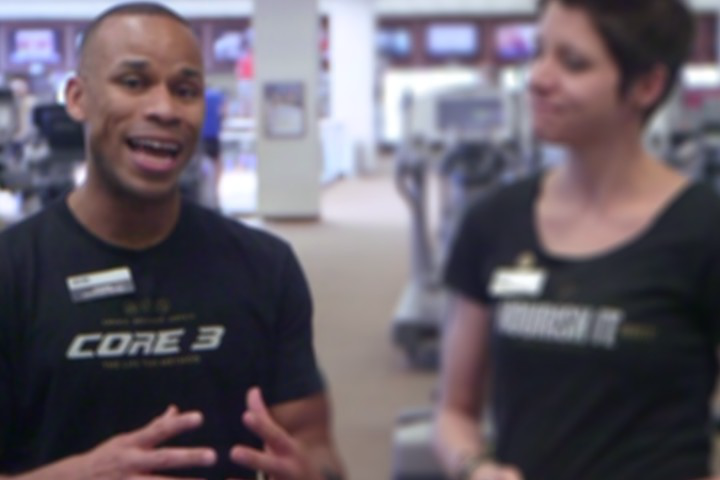

In [19]:
#test the CropRescale transform
im=load_frame(instances[10])
#im = Grayscale(num_output_channels=1)(im)
#im_res = RescaleCrop(crop_size = (480,720), kernel_width=1)(im)
im_res = Multifuz(crop_size = (480,720),
                  kernel_range=(1,16), 
                  quality_range=(90,90), 
                  slope_range=(0.0001, 0.1),
                 radius_range=(.05,.5),
                 scale_range=(1/2,2))(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [20]:


def input_transform(crop_size, kernel_range):
    
    
    return Compose([
        
        Multifuz(crop_size = crop_size,
                  kernel_range=kernel_range, 
                  quality_range=(30,90), 
                  slope_range=(0.00001, 0.01),
                 radius_range=(.05,.75),
                 scale_range=(1/2,2)), 
        Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    print(crop_size)
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])



def test_input_transform(crop_size, kernel_size, quality):
    
    return Compose([
        Crappify(crop_size=crop_size, kernel_size=kernel_size, quality=quality),
        ToTensor()
    ])


def get_training_set(data_dir, crop_size, kernel_range, frame_sample_size=10, add_noise=None, 
                     noise_std=3.0,Flip_hor=True,Rand_bright_contrast=True):
    

    cropsize = crop_size
    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=input_transform(
                                 crop_size, kernel_range),
                             target_transform=target_transform(crop_size),
                             add_noise=add_noise,
                             noise_std=noise_std,Flip_hor=Flip_hor,
                             Rand_bright_contrast=Rand_bright_contrast)


## Below functions need work

def get_validation_set(data_dir, crop_size, kernel_range):
    
    
    return DatasetFromVideoFolder(data_dir,frame_sample_size,
                             input_transform=input_transform(
                                 cropsize, kernel_range,frame_sample_size=10),
                             target_transform=target_transform(cropsize))


def get_test_set(data_dir, crop_size, kernel_size, quality, frame_sample_size=10):


    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=test_input_transform(
                                 crop_size, kernel_size, quality),
                             target_transform=ToTensor(),
                             add_noise=None,
                             noise_std=3,Flip_hor=False,
                             Rand_bright_contrast=False)

In [21]:
#settings
train_dir = "/media/SSD/superres/video_data/train_data"
frame_sample_size =10
batch_size = 4 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
kernel_range=(1,20)
add_noise=False
noise_std=3.0
Flip_hor=True
Rand_bright_contrast=True

In [22]:
# create a data set
# split it using random split
# random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))


In [23]:
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            kernel_range=kernel_range,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

(480, 720)


In [24]:
# measurement of blur of an image
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [25]:

def show_batch(dataloader,size = 8):

    inputs, outputs = next(iter(dataloader))
    print(inputs.shape)
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    outputs = outputs.numpy().transpose((0, 2, 3, 1))
    
    
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = 2*size, 4*size
    fig=plt.figure(figsize=(w, h))
    columns = 2
    rows = 4
    ax=[]
    
    for i in range(0, rows):
        blur_measure_input = variance_of_laplacian((inputs[i]*255).astype(np.uint8))
        blur_measure_output = variance_of_laplacian((outputs[i]*255).astype(np.uint8))
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        ax[-1].set_title('Blur: '+str(blur_measure_input))
        plt.imshow((inputs[i]*255).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        ax[-1].set_title('Blur: '+str(blur_measure_output))
        plt.imshow((outputs[i]*255).astype(np.uint8),cmap='gray')
    plt.show()

torch.Size([4, 1, 480, 720])


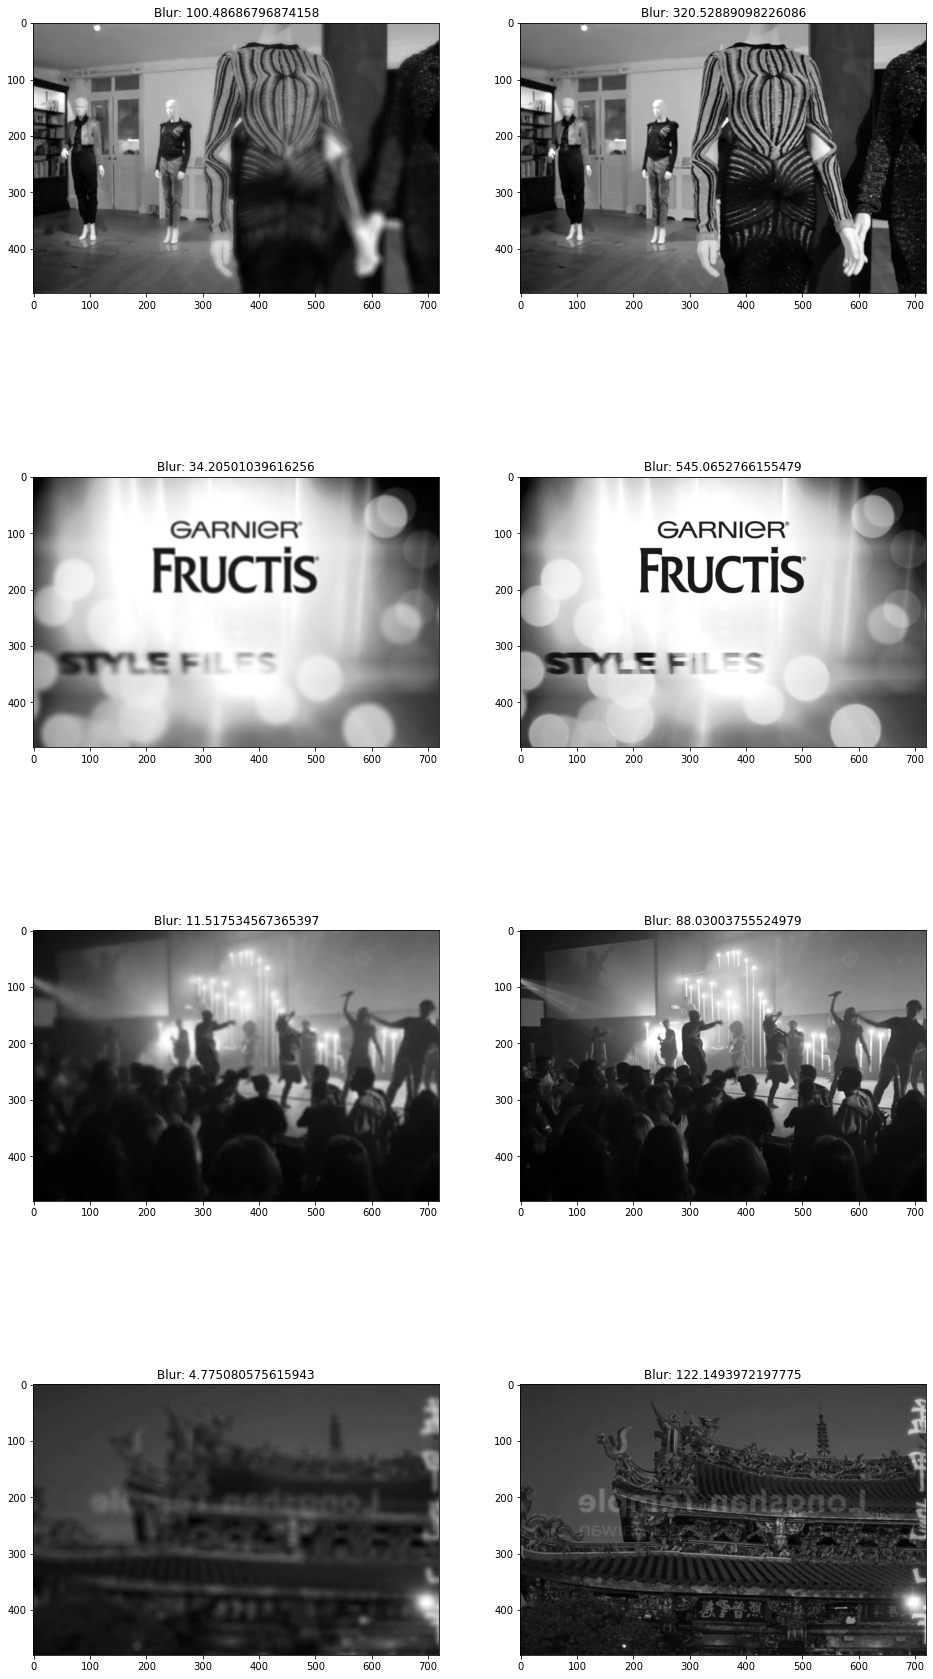

In [26]:
show_batch(training_data_loader,size =8)

# VDSR with dropout

In [ ]:
import torch.nn as nn
from math import sqrt

class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.do = nn.Dropout2d(p=0.5, inplace=True)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))
        
class VDSRNet(nn.Module):
    def __init__(self):
        super(VDSRNet, self).__init__()
        self.residual_layer = self.make_layer(Conv_ReLU_Block, 18)
        self.input = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out
    
    


# ESPCN

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))


class ESPCNNet(nn.Module):
    def __init__(self, upscale_factor):
        super(ESPCNNet, self).__init__()

        self.upscale_factor = upscale_factor
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv1a = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv1b = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv1c = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv1d = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv2 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(32, 1 * (upscale_factor ** 2), (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        self.relu = nn.ReLU(inplace=True)
        

    def forward(self, x):
        
        #residual = x
        #residual = F.interpolate(x, size=None, scale_factor=self.upscale_factor, mode='bicubic',
        #                         align_corners=True, recompute_scale_factor=None).clamp(min=0.0, max=1.0)
        
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.relu(self.conv1c(x))
        x = self.relu(self.conv1d(x))
        x = self.relu(self.conv2(x))
        x = F.sigmoid(self.pixel_shuffle(self.conv3(x)))
        
        #x = torch.add(x,residual)
        
        return x
    
# Make it use a residual approach -Add the network to bicubic interpolation at end resolution - just like VDSR

# Build the model

In [29]:
#model = VDSRNet()
model = ESPCNNet(upscale_factor=1)
model.cuda()


ESPCNNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv1a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1c): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1d): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=1)
  (relu): ReLU(inplace=True)
)

In [ ]:
model = torch.load("/media/SSD/superres/pytorch-vdsr/model/model_epoch_50.pth")["model"]



In [30]:
from torchsummary import summary
summary(model, (1, 480, 720));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 480, 720]        576
├─ReLU: 1-2                              [-1, 64, 480, 720]        --
├─Conv2d: 1-3                            [-1, 64, 480, 720]        36,928
├─ReLU: 1-4                              [-1, 64, 480, 720]        --
├─Conv2d: 1-5                            [-1, 64, 480, 720]        36,928
├─ReLU: 1-6                              [-1, 64, 480, 720]        --
├─Conv2d: 1-7                            [-1, 64, 480, 720]        36,928
├─ReLU: 1-8                              [-1, 64, 480, 720]        --
├─Conv2d: 1-9                            [-1, 64, 480, 720]        36,928
├─ReLU: 1-10                             [-1, 64, 480, 720]        --
├─Conv2d: 1-11                           [-1, 32, 480, 720]        18,464
├─ReLU: 1-12                             [-1, 32, 480, 720]        --
├─Conv2d: 1-13                           [-1, 1, 480, 720]      

/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [31]:
criterion2 = nn.MSELoss(reduction = 'sum')
#criterion = nn.L1Loss(reduction = 'sum')

#loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
#loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

loss_fn = lpips.LPIPS(net='alex')
loss_fn.cuda()

def loss_scaler(im):
    # scale to -1,1 and convert to 3 channel (greyscale to RBG)
    return (im * 2 - 1).expand(-1, 3, -1, -1)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /media/SSD/conda_env/superres/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [32]:
class P_Loss(torch.nn.Module):
    
    def __init__(self):
        super(P_Loss,self).__init__()
        
    def forward(self,x,y):
        
        totloss = torch.mean(loss_fn.forward(loss_scaler(x),loss_scaler(y)))
        
        # approach to split image into blocks since loss works on 256x256 images
        for i in [0, 224]:
            for j in [0, 232, 464 ]:
                x_crop = x[:,:,i:i+255, j:j+255]
                y_crop = y[:,:,i:i+255, j:j+255]
                totloss.add_(torch.mean(loss_fn.forward(loss_scaler(x_crop),loss_scaler(y_crop)))/6)
        
        #print("before:",totloss)
        
        #also use mse loss
        #totloss.add_(torch.mean(loss_fn_2.forward(x,y)))
        
        #print("after:",totloss)
        #do we need to work in color?
        
        return totloss

In [33]:
list(range(0,1280-256,256-int((256*6-1280)/5)))

[0, 205, 410, 615, 820]

In [34]:
list(range(0,720-256,256-int((256*3-720)/2)))

[0, 232]

In [35]:
criterion = P_Loss()

#criterion.cuda()

In [36]:
init_lr = .01
lr_step = 5
gradient_clip = 0.4
epochs = 40

In [37]:
#optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)

In [38]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [39]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [40]:
def save_checkpoint(model, epoch):
    model_out_path = "checkpoint/" + "ESPCN2_epoch_{}.pth".format(epoch)
    state = {"epoch": epoch ,"model": model}
    if not os.path.exists("checkpoint/"):
        os.makedirs("checkpoint/")

    torch.save(state, model_out_path)

    print("Checkpoint saved to {}".format(model_out_path))

In [41]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

In [42]:
def trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    cum_loss2=0
    cum_loss = 0
    ct=0
    ct2=0

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

        
        input = input.cuda()
        target = target.cuda()
        
        # Runs the forward pass with autocasting.
        with autocast():
            output = model(input)
            #loss = criterion(output, target) + criterion2(output, target)/5000.0
            loss = criterion2(output, target)
            
        
        optimizer.zero_grad()
        
        scaler.scale(loss).backward()
        #loss.backward() 
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 
        
        #optimizer.step()
        scaler.step(optimizer)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        #scheduler.step()
        
        cum_loss = cum_loss + loss.data
        cum_loss2 = cum_loss2 + loss.data
        ct2=ct2+batch_size
        ct = ct +batch_size
        

        if iteration%10 == 0:
            dt = str(datetime.datetime.now())
            print("===> Time: {} Epoch[{}]({}/{}): LR: {} : Loss: {:.10f}".format(dt,epoch, iteration, len(training_data_loader), optimizer.param_groups[0]["lr"], cum_loss/ct))
            ct=0
            cum_loss =0
    print("Epoch Loss:", cum_loss2/ct2)        

In [43]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        save_checkpoint(model, epoch)

Start Time: 2020-09-30 15:47:45.000696
Epoch = 1, lr = 0.01
===> Time: 2020-09-30 15:47:52.154255 Epoch[1](10/1586): LR: 0.01 : Loss: 38500.5820312500
===> Time: 2020-09-30 15:47:59.089773 Epoch[1](20/1586): LR: 0.01 : Loss: 56434.6250000000
===> Time: 2020-09-30 15:48:06.362336 Epoch[1](30/1586): LR: 0.01 : Loss: 93802.3125000000
===> Time: 2020-09-30 15:48:13.562946 Epoch[1](40/1586): LR: 0.01 : Loss: 19802.9746093750
===> Time: 2020-09-30 15:48:20.728109 Epoch[1](50/1586): LR: 0.01 : Loss: 23781.5371093750
===> Time: 2020-09-30 15:48:27.630254 Epoch[1](60/1586): LR: 0.01 : Loss: 14238.1093750000
===> Time: 2020-09-30 15:48:34.763144 Epoch[1](70/1586): LR: 0.01 : Loss: 13981.7802734375
===> Time: 2020-09-30 15:48:42.098965 Epoch[1](80/1586): LR: 0.01 : Loss: 7159.1547851562
===> Time: 2020-09-30 15:48:49.045467 Epoch[1](90/1586): LR: 0.01 : Loss: 3459.6601562500
===> Time: 2020-09-30 15:48:55.998127 Epoch[1](100/1586): LR: 0.01 : Loss: 4606.3583984375
===> Time: 2020-09-30 15:49:03.0

===> Time: 2020-09-30 15:58:22.581514 Epoch[1](910/1586): LR: 0.01 : Loss: 3848.3852539062
===> Time: 2020-09-30 15:58:29.485805 Epoch[1](920/1586): LR: 0.01 : Loss: 2523.5617675781
===> Time: 2020-09-30 15:58:36.500115 Epoch[1](930/1586): LR: 0.01 : Loss: 1844.0797119141
===> Time: 2020-09-30 15:58:43.443082 Epoch[1](940/1586): LR: 0.01 : Loss: 3259.3034667969
===> Time: 2020-09-30 15:58:50.546827 Epoch[1](950/1586): LR: 0.01 : Loss: 2810.1618652344
===> Time: 2020-09-30 15:58:57.686816 Epoch[1](960/1586): LR: 0.01 : Loss: 2858.7751464844
===> Time: 2020-09-30 15:59:04.858598 Epoch[1](970/1586): LR: 0.01 : Loss: 1749.9810791016
===> Time: 2020-09-30 15:59:12.135265 Epoch[1](980/1586): LR: 0.01 : Loss: 3049.6262207031
===> Time: 2020-09-30 15:59:19.065069 Epoch[1](990/1586): LR: 0.01 : Loss: 2149.8937988281
===> Time: 2020-09-30 15:59:26.275343 Epoch[1](1000/1586): LR: 0.01 : Loss: 2224.0197753906
===> Time: 2020-09-30 15:59:33.321037 Epoch[1](1010/1586): LR: 0.01 : Loss: 2645.25585937

===> Time: 2020-09-30 16:08:40.029137 Epoch[2](210/1586): LR: 0.01 : Loss: 2136.4523925781
===> Time: 2020-09-30 16:08:46.666466 Epoch[2](220/1586): LR: 0.01 : Loss: 2707.7946777344
===> Time: 2020-09-30 16:08:53.691544 Epoch[2](230/1586): LR: 0.01 : Loss: 1950.5263671875
===> Time: 2020-09-30 16:09:00.488882 Epoch[2](240/1586): LR: 0.01 : Loss: 2573.5329589844
===> Time: 2020-09-30 16:09:07.393257 Epoch[2](250/1586): LR: 0.01 : Loss: 2401.4824218750
===> Time: 2020-09-30 16:09:14.249627 Epoch[2](260/1586): LR: 0.01 : Loss: 2558.4411621094
===> Time: 2020-09-30 16:09:21.246073 Epoch[2](270/1586): LR: 0.01 : Loss: 2125.0319824219
===> Time: 2020-09-30 16:09:28.402052 Epoch[2](280/1586): LR: 0.01 : Loss: 4411.0170898438
===> Time: 2020-09-30 16:09:35.397141 Epoch[2](290/1586): LR: 0.01 : Loss: 4422.4873046875
===> Time: 2020-09-30 16:09:42.197742 Epoch[2](300/1586): LR: 0.01 : Loss: 3544.8085937500
===> Time: 2020-09-30 16:09:49.039161 Epoch[2](310/1586): LR: 0.01 : Loss: 2757.3122558594

===> Time: 2020-09-30 16:19:03.734830 Epoch[2](1110/1586): LR: 0.01 : Loss: 2580.8825683594
===> Time: 2020-09-30 16:19:10.733753 Epoch[2](1120/1586): LR: 0.01 : Loss: 2899.9716796875
===> Time: 2020-09-30 16:19:17.544581 Epoch[2](1130/1586): LR: 0.01 : Loss: 2247.3129882812
===> Time: 2020-09-30 16:19:24.320201 Epoch[2](1140/1586): LR: 0.01 : Loss: 5058.0571289062
===> Time: 2020-09-30 16:19:31.170711 Epoch[2](1150/1586): LR: 0.01 : Loss: 2599.2893066406
===> Time: 2020-09-30 16:19:38.070677 Epoch[2](1160/1586): LR: 0.01 : Loss: 4738.9438476562
===> Time: 2020-09-30 16:19:44.802472 Epoch[2](1170/1586): LR: 0.01 : Loss: 2972.3239746094
===> Time: 2020-09-30 16:19:51.878272 Epoch[2](1180/1586): LR: 0.01 : Loss: 2210.3747558594
===> Time: 2020-09-30 16:19:58.774784 Epoch[2](1190/1586): LR: 0.01 : Loss: 5353.7104492188
===> Time: 2020-09-30 16:20:05.582693 Epoch[2](1200/1586): LR: 0.01 : Loss: 2613.2009277344
===> Time: 2020-09-30 16:20:12.512503 Epoch[2](1210/1586): LR: 0.01 : Loss: 2765

===> Time: 2020-09-30 16:29:17.000615 Epoch[3](410/1586): LR: 0.01 : Loss: 2833.8972167969
===> Time: 2020-09-30 16:29:23.723138 Epoch[3](420/1586): LR: 0.01 : Loss: 2378.7868652344
===> Time: 2020-09-30 16:29:30.747218 Epoch[3](430/1586): LR: 0.01 : Loss: 1870.3426513672
===> Time: 2020-09-30 16:29:37.648759 Epoch[3](440/1586): LR: 0.01 : Loss: 3822.2785644531
===> Time: 2020-09-30 16:29:44.714283 Epoch[3](450/1586): LR: 0.01 : Loss: 9762.6083984375
===> Time: 2020-09-30 16:29:51.690181 Epoch[3](460/1586): LR: 0.01 : Loss: 7144.5742187500
===> Time: 2020-09-30 16:29:58.710604 Epoch[3](470/1586): LR: 0.01 : Loss: 14205.2001953125
===> Time: 2020-09-30 16:30:05.788544 Epoch[3](480/1586): LR: 0.01 : Loss: 6980.5322265625
===> Time: 2020-09-30 16:30:12.505087 Epoch[3](490/1586): LR: 0.01 : Loss: 6840.9233398438
===> Time: 2020-09-30 16:30:19.436032 Epoch[3](500/1586): LR: 0.01 : Loss: 4247.1323242188
===> Time: 2020-09-30 16:30:26.473633 Epoch[3](510/1586): LR: 0.01 : Loss: 2503.265380859

===> Time: 2020-09-30 16:39:38.969289 Epoch[3](1310/1586): LR: 0.01 : Loss: 1831.5507812500
===> Time: 2020-09-30 16:39:45.815766 Epoch[3](1320/1586): LR: 0.01 : Loss: 2731.7421875000
===> Time: 2020-09-30 16:39:52.600121 Epoch[3](1330/1586): LR: 0.01 : Loss: 2708.6726074219
===> Time: 2020-09-30 16:39:59.511313 Epoch[3](1340/1586): LR: 0.01 : Loss: 2332.6586914062
===> Time: 2020-09-30 16:40:06.507200 Epoch[3](1350/1586): LR: 0.01 : Loss: 3325.9196777344
===> Time: 2020-09-30 16:40:13.355852 Epoch[3](1360/1586): LR: 0.01 : Loss: 2415.1845703125
===> Time: 2020-09-30 16:40:20.042180 Epoch[3](1370/1586): LR: 0.01 : Loss: 4082.8220214844
===> Time: 2020-09-30 16:40:26.935154 Epoch[3](1380/1586): LR: 0.01 : Loss: 4455.3291015625
===> Time: 2020-09-30 16:40:33.931612 Epoch[3](1390/1586): LR: 0.01 : Loss: 3993.5305175781
===> Time: 2020-09-30 16:40:40.552418 Epoch[3](1400/1586): LR: 0.01 : Loss: 2504.5136718750
===> Time: 2020-09-30 16:40:47.450387 Epoch[3](1410/1586): LR: 0.01 : Loss: 2690

===> Time: 2020-09-30 16:49:56.303044 Epoch[4](620/1586): LR: 0.01 : Loss: 3636.7575683594
===> Time: 2020-09-30 16:50:03.381410 Epoch[4](630/1586): LR: 0.01 : Loss: 4119.1757812500
===> Time: 2020-09-30 16:50:10.256493 Epoch[4](640/1586): LR: 0.01 : Loss: 4149.6577148438
===> Time: 2020-09-30 16:50:17.209573 Epoch[4](650/1586): LR: 0.01 : Loss: 3236.5219726562
===> Time: 2020-09-30 16:50:23.962057 Epoch[4](660/1586): LR: 0.01 : Loss: 2235.3378906250
===> Time: 2020-09-30 16:50:30.811599 Epoch[4](670/1586): LR: 0.01 : Loss: 3414.2524414062
===> Time: 2020-09-30 16:50:37.507959 Epoch[4](680/1586): LR: 0.01 : Loss: 3242.3395996094
===> Time: 2020-09-30 16:50:44.391160 Epoch[4](690/1586): LR: 0.01 : Loss: 1827.7332763672
===> Time: 2020-09-30 16:50:51.268799 Epoch[4](700/1586): LR: 0.01 : Loss: 2703.2761230469
===> Time: 2020-09-30 16:50:58.074629 Epoch[4](710/1586): LR: 0.01 : Loss: 1838.5316162109
===> Time: 2020-09-30 16:51:04.990672 Epoch[4](720/1586): LR: 0.01 : Loss: 2038.3378906250

===> Time: 2020-09-30 17:00:19.088746 Epoch[4](1520/1586): LR: 0.01 : Loss: 2605.9479980469
===> Time: 2020-09-30 17:00:25.898241 Epoch[4](1530/1586): LR: 0.01 : Loss: 3132.3386230469
===> Time: 2020-09-30 17:00:32.863713 Epoch[4](1540/1586): LR: 0.01 : Loss: 4659.0874023438
===> Time: 2020-09-30 17:00:39.838076 Epoch[4](1550/1586): LR: 0.01 : Loss: 2471.7731933594
===> Time: 2020-09-30 17:00:46.955054 Epoch[4](1560/1586): LR: 0.01 : Loss: 2206.1894531250
===> Time: 2020-09-30 17:00:53.853517 Epoch[4](1570/1586): LR: 0.01 : Loss: 1827.8109130859
===> Time: 2020-09-30 17:01:00.708731 Epoch[4](1580/1586): LR: 0.01 : Loss: 1932.7597656250
Epoch Loss: tensor(2945.5083, device='cuda:0')
Checkpoint saved to checkpoint/ESPCN2_epoch_4.pth
Start Time: 2020-09-30 17:01:04.611278
Epoch = 5, lr = 0.01
===> Time: 2020-09-30 17:01:11.687383 Epoch[5](10/1586): LR: 0.01 : Loss: 2224.6816406250
===> Time: 2020-09-30 17:01:18.710381 Epoch[5](20/1586): LR: 0.01 : Loss: 2137.8481445312
===> Time: 2020-09-

===> Time: 2020-09-30 17:10:39.979948 Epoch[5](830/1586): LR: 0.01 : Loss: 3147.5456542969
===> Time: 2020-09-30 17:10:46.911660 Epoch[5](840/1586): LR: 0.01 : Loss: 2361.1508789062
===> Time: 2020-09-30 17:10:53.853604 Epoch[5](850/1586): LR: 0.01 : Loss: 3242.5202636719
===> Time: 2020-09-30 17:11:01.076175 Epoch[5](860/1586): LR: 0.01 : Loss: 2580.0017089844
===> Time: 2020-09-30 17:11:07.997628 Epoch[5](870/1586): LR: 0.01 : Loss: 2756.9460449219
===> Time: 2020-09-30 17:11:14.815601 Epoch[5](880/1586): LR: 0.01 : Loss: 3699.7102050781
===> Time: 2020-09-30 17:11:21.709869 Epoch[5](890/1586): LR: 0.01 : Loss: 2730.8444824219
===> Time: 2020-09-30 17:11:28.720822 Epoch[5](900/1586): LR: 0.01 : Loss: 2201.6052246094
===> Time: 2020-09-30 17:11:35.799583 Epoch[5](910/1586): LR: 0.01 : Loss: 3987.0422363281
===> Time: 2020-09-30 17:11:42.755468 Epoch[5](920/1586): LR: 0.01 : Loss: 3920.9492187500
===> Time: 2020-09-30 17:11:49.682198 Epoch[5](930/1586): LR: 0.01 : Loss: 3738.7214355469

===> Time: 2020-09-30 17:20:40.567516 Epoch[6](110/1586): LR: 0.0031622776601683794 : Loss: 2165.3637695312
===> Time: 2020-09-30 17:20:47.350370 Epoch[6](120/1586): LR: 0.0031622776601683794 : Loss: 2590.7937011719
===> Time: 2020-09-30 17:20:54.243796 Epoch[6](130/1586): LR: 0.0031622776601683794 : Loss: 1919.5755615234
===> Time: 2020-09-30 17:21:01.215445 Epoch[6](140/1586): LR: 0.0031622776601683794 : Loss: 1822.1097412109
===> Time: 2020-09-30 17:21:08.202573 Epoch[6](150/1586): LR: 0.0031622776601683794 : Loss: 2008.1279296875
===> Time: 2020-09-30 17:21:15.009090 Epoch[6](160/1586): LR: 0.0031622776601683794 : Loss: 1367.9138183594
===> Time: 2020-09-30 17:21:21.844414 Epoch[6](170/1586): LR: 0.0031622776601683794 : Loss: 1876.7792968750
===> Time: 2020-09-30 17:21:28.920265 Epoch[6](180/1586): LR: 0.0031622776601683794 : Loss: 2377.6582031250
===> Time: 2020-09-30 17:21:35.782467 Epoch[6](190/1586): LR: 0.0031622776601683794 : Loss: 2354.0603027344
===> Time: 2020-09-30 17:21:

===> Time: 2020-09-30 17:29:24.831893 Epoch[6](870/1586): LR: 0.0031622776601683794 : Loss: 2903.1979980469
===> Time: 2020-09-30 17:29:31.808296 Epoch[6](880/1586): LR: 0.0031622776601683794 : Loss: 1990.1096191406
===> Time: 2020-09-30 17:29:38.819079 Epoch[6](890/1586): LR: 0.0031622776601683794 : Loss: 1793.3226318359
===> Time: 2020-09-30 17:29:45.708675 Epoch[6](900/1586): LR: 0.0031622776601683794 : Loss: 3572.6796875000
===> Time: 2020-09-30 17:29:52.692967 Epoch[6](910/1586): LR: 0.0031622776601683794 : Loss: 2119.9868164062
===> Time: 2020-09-30 17:29:59.670919 Epoch[6](920/1586): LR: 0.0031622776601683794 : Loss: 1943.6082763672
===> Time: 2020-09-30 17:30:06.744817 Epoch[6](930/1586): LR: 0.0031622776601683794 : Loss: 2073.3398437500
===> Time: 2020-09-30 17:30:13.949056 Epoch[6](940/1586): LR: 0.0031622776601683794 : Loss: 1697.5852050781
===> Time: 2020-09-30 17:30:20.792946 Epoch[6](950/1586): LR: 0.0031622776601683794 : Loss: 2571.6171875000
===> Time: 2020-09-30 17:30:

===> Time: 2020-09-30 17:38:01.111721 Epoch[7](30/1586): LR: 0.0031622776601683794 : Loss: 2068.2404785156
===> Time: 2020-09-30 17:38:08.002280 Epoch[7](40/1586): LR: 0.0031622776601683794 : Loss: 1680.7320556641
===> Time: 2020-09-30 17:38:14.858258 Epoch[7](50/1586): LR: 0.0031622776601683794 : Loss: 2095.4318847656
===> Time: 2020-09-30 17:38:21.958353 Epoch[7](60/1586): LR: 0.0031622776601683794 : Loss: 1596.1829833984
===> Time: 2020-09-30 17:38:28.686958 Epoch[7](70/1586): LR: 0.0031622776601683794 : Loss: 2778.3708496094
===> Time: 2020-09-30 17:38:35.792160 Epoch[7](80/1586): LR: 0.0031622776601683794 : Loss: 2195.4353027344
===> Time: 2020-09-30 17:38:42.711017 Epoch[7](90/1586): LR: 0.0031622776601683794 : Loss: 2454.8649902344
===> Time: 2020-09-30 17:38:49.658671 Epoch[7](100/1586): LR: 0.0031622776601683794 : Loss: 3745.0183105469
===> Time: 2020-09-30 17:38:56.511282 Epoch[7](110/1586): LR: 0.0031622776601683794 : Loss: 1600.3957519531
===> Time: 2020-09-30 17:39:03.3615

===> Time: 2020-09-30 17:46:46.119430 Epoch[7](790/1586): LR: 0.0031622776601683794 : Loss: 2239.0095214844
===> Time: 2020-09-30 17:46:53.028178 Epoch[7](800/1586): LR: 0.0031622776601683794 : Loss: 2361.5368652344
===> Time: 2020-09-30 17:47:00.036050 Epoch[7](810/1586): LR: 0.0031622776601683794 : Loss: 2332.6989746094
===> Time: 2020-09-30 17:47:07.085020 Epoch[7](820/1586): LR: 0.0031622776601683794 : Loss: 1446.5540771484
===> Time: 2020-09-30 17:47:14.142975 Epoch[7](830/1586): LR: 0.0031622776601683794 : Loss: 3017.1293945312
===> Time: 2020-09-30 17:47:21.087501 Epoch[7](840/1586): LR: 0.0031622776601683794 : Loss: 1855.7607421875
===> Time: 2020-09-30 17:47:27.957218 Epoch[7](850/1586): LR: 0.0031622776601683794 : Loss: 1689.0595703125
===> Time: 2020-09-30 17:47:34.978589 Epoch[7](860/1586): LR: 0.0031622776601683794 : Loss: 4327.6342773438
===> Time: 2020-09-30 17:47:41.899661 Epoch[7](870/1586): LR: 0.0031622776601683794 : Loss: 2820.9909667969
===> Time: 2020-09-30 17:47:

===> Time: 2020-09-30 17:55:33.719748 Epoch[7](1550/1586): LR: 0.0031622776601683794 : Loss: 3265.1071777344
===> Time: 2020-09-30 17:55:40.698117 Epoch[7](1560/1586): LR: 0.0031622776601683794 : Loss: 4661.1596679688
===> Time: 2020-09-30 17:55:47.528579 Epoch[7](1570/1586): LR: 0.0031622776601683794 : Loss: 4137.9116210938
===> Time: 2020-09-30 17:55:54.395391 Epoch[7](1580/1586): LR: 0.0031622776601683794 : Loss: 2906.8376464844
Epoch Loss: tensor(2334.6177, device='cuda:0')
Checkpoint saved to checkpoint/ESPCN2_epoch_7.pth
Start Time: 2020-09-30 17:55:58.361378
Epoch = 8, lr = 0.0031622776601683794
===> Time: 2020-09-30 17:56:05.285413 Epoch[8](10/1586): LR: 0.0031622776601683794 : Loss: 2499.2751464844
===> Time: 2020-09-30 17:56:12.230406 Epoch[8](20/1586): LR: 0.0031622776601683794 : Loss: 2062.7399902344
===> Time: 2020-09-30 17:56:19.178055 Epoch[8](30/1586): LR: 0.0031622776601683794 : Loss: 1521.6492919922
===> Time: 2020-09-30 17:56:26.035370 Epoch[8](40/1586): LR: 0.003162

===> Time: 2020-09-30 18:04:16.945371 Epoch[8](720/1586): LR: 0.0031622776601683794 : Loss: 2565.8449707031
===> Time: 2020-09-30 18:04:23.793619 Epoch[8](730/1586): LR: 0.0031622776601683794 : Loss: 2951.0390625000
===> Time: 2020-09-30 18:04:30.551638 Epoch[8](740/1586): LR: 0.0031622776601683794 : Loss: 2501.7961425781
===> Time: 2020-09-30 18:04:37.465388 Epoch[8](750/1586): LR: 0.0031622776601683794 : Loss: 2039.2606201172
===> Time: 2020-09-30 18:04:44.470610 Epoch[8](760/1586): LR: 0.0031622776601683794 : Loss: 2192.3391113281
===> Time: 2020-09-30 18:04:51.309575 Epoch[8](770/1586): LR: 0.0031622776601683794 : Loss: 2239.9592285156
===> Time: 2020-09-30 18:04:58.029941 Epoch[8](780/1586): LR: 0.0031622776601683794 : Loss: 2311.2597656250
===> Time: 2020-09-30 18:05:05.011951 Epoch[8](790/1586): LR: 0.0031622776601683794 : Loss: 1929.7586669922
===> Time: 2020-09-30 18:05:11.827929 Epoch[8](800/1586): LR: 0.0031622776601683794 : Loss: 4032.5397949219
===> Time: 2020-09-30 18:05:

===> Time: 2020-09-30 18:13:03.390376 Epoch[8](1480/1586): LR: 0.0031622776601683794 : Loss: 2339.2507324219
===> Time: 2020-09-30 18:13:10.410660 Epoch[8](1490/1586): LR: 0.0031622776601683794 : Loss: 6584.8032226562
===> Time: 2020-09-30 18:13:17.259168 Epoch[8](1500/1586): LR: 0.0031622776601683794 : Loss: 3057.2990722656
===> Time: 2020-09-30 18:13:24.213512 Epoch[8](1510/1586): LR: 0.0031622776601683794 : Loss: 3572.4675292969
===> Time: 2020-09-30 18:13:31.140490 Epoch[8](1520/1586): LR: 0.0031622776601683794 : Loss: 2531.1940917969
===> Time: 2020-09-30 18:13:38.051607 Epoch[8](1530/1586): LR: 0.0031622776601683794 : Loss: 2527.5466308594
===> Time: 2020-09-30 18:13:44.806557 Epoch[8](1540/1586): LR: 0.0031622776601683794 : Loss: 3354.4277343750
===> Time: 2020-09-30 18:13:51.779732 Epoch[8](1550/1586): LR: 0.0031622776601683794 : Loss: 1964.6035156250
===> Time: 2020-09-30 18:13:58.499535 Epoch[8](1560/1586): LR: 0.0031622776601683794 : Loss: 2914.4343261719
===> Time: 2020-09-

===> Time: 2020-09-30 18:21:46.021665 Epoch[9](650/1586): LR: 0.0031622776601683794 : Loss: 2354.4650878906
===> Time: 2020-09-30 18:21:52.910784 Epoch[9](660/1586): LR: 0.0031622776601683794 : Loss: 1888.6478271484
===> Time: 2020-09-30 18:21:59.934355 Epoch[9](670/1586): LR: 0.0031622776601683794 : Loss: 1918.3369140625
===> Time: 2020-09-30 18:22:06.892776 Epoch[9](680/1586): LR: 0.0031622776601683794 : Loss: 1651.2679443359
===> Time: 2020-09-30 18:22:13.697099 Epoch[9](690/1586): LR: 0.0031622776601683794 : Loss: 1618.0892333984
===> Time: 2020-09-30 18:22:20.687248 Epoch[9](700/1586): LR: 0.0031622776601683794 : Loss: 2093.8034667969
===> Time: 2020-09-30 18:22:27.856124 Epoch[9](710/1586): LR: 0.0031622776601683794 : Loss: 1934.9293212891
===> Time: 2020-09-30 18:22:34.635122 Epoch[9](720/1586): LR: 0.0031622776601683794 : Loss: 2610.9011230469
===> Time: 2020-09-30 18:22:41.526001 Epoch[9](730/1586): LR: 0.0031622776601683794 : Loss: 2611.9003906250
===> Time: 2020-09-30 18:22:

===> Time: 2020-09-30 18:30:33.095740 Epoch[9](1410/1586): LR: 0.0031622776601683794 : Loss: 2610.9863281250
===> Time: 2020-09-30 18:30:39.855065 Epoch[9](1420/1586): LR: 0.0031622776601683794 : Loss: 2805.3688964844
===> Time: 2020-09-30 18:30:46.702407 Epoch[9](1430/1586): LR: 0.0031622776601683794 : Loss: 2095.9677734375
===> Time: 2020-09-30 18:30:53.520511 Epoch[9](1440/1586): LR: 0.0031622776601683794 : Loss: 1875.4328613281
===> Time: 2020-09-30 18:31:00.398727 Epoch[9](1450/1586): LR: 0.0031622776601683794 : Loss: 2587.3503417969
===> Time: 2020-09-30 18:31:07.450238 Epoch[9](1460/1586): LR: 0.0031622776601683794 : Loss: 3560.7910156250
===> Time: 2020-09-30 18:31:14.341997 Epoch[9](1470/1586): LR: 0.0031622776601683794 : Loss: 1821.3750000000
===> Time: 2020-09-30 18:31:21.162344 Epoch[9](1480/1586): LR: 0.0031622776601683794 : Loss: 1820.4622802734
===> Time: 2020-09-30 18:31:28.074491 Epoch[9](1490/1586): LR: 0.0031622776601683794 : Loss: 2342.6042480469
===> Time: 2020-09-

===> Time: 2020-09-30 18:39:14.862749 Epoch[10](570/1586): LR: 0.0031622776601683794 : Loss: 1902.7528076172
===> Time: 2020-09-30 18:39:21.723085 Epoch[10](580/1586): LR: 0.0031622776601683794 : Loss: 1904.4957275391
===> Time: 2020-09-30 18:39:28.471652 Epoch[10](590/1586): LR: 0.0031622776601683794 : Loss: 1727.0775146484
===> Time: 2020-09-30 18:39:35.403636 Epoch[10](600/1586): LR: 0.0031622776601683794 : Loss: 1820.9973144531
===> Time: 2020-09-30 18:39:42.309112 Epoch[10](610/1586): LR: 0.0031622776601683794 : Loss: 1812.8599853516
===> Time: 2020-09-30 18:39:49.305158 Epoch[10](620/1586): LR: 0.0031622776601683794 : Loss: 2087.3916015625
===> Time: 2020-09-30 18:39:56.356593 Epoch[10](630/1586): LR: 0.0031622776601683794 : Loss: 2848.9614257812
===> Time: 2020-09-30 18:40:03.463828 Epoch[10](640/1586): LR: 0.0031622776601683794 : Loss: 1652.4475097656
===> Time: 2020-09-30 18:40:10.378552 Epoch[10](650/1586): LR: 0.0031622776601683794 : Loss: 2437.1384277344
===> Time: 2020-09-

===> Time: 2020-09-30 18:47:55.945323 Epoch[10](1320/1586): LR: 0.0031622776601683794 : Loss: 1570.8780517578
===> Time: 2020-09-30 18:48:02.823576 Epoch[10](1330/1586): LR: 0.0031622776601683794 : Loss: 2311.2556152344
===> Time: 2020-09-30 18:48:09.829436 Epoch[10](1340/1586): LR: 0.0031622776601683794 : Loss: 2024.6074218750
===> Time: 2020-09-30 18:48:16.856515 Epoch[10](1350/1586): LR: 0.0031622776601683794 : Loss: 2271.6613769531
===> Time: 2020-09-30 18:48:23.840815 Epoch[10](1360/1586): LR: 0.0031622776601683794 : Loss: 1875.1156005859
===> Time: 2020-09-30 18:48:30.637481 Epoch[10](1370/1586): LR: 0.0031622776601683794 : Loss: 1970.9996337891
===> Time: 2020-09-30 18:48:37.553032 Epoch[10](1380/1586): LR: 0.0031622776601683794 : Loss: 2226.3105468750
===> Time: 2020-09-30 18:48:44.323728 Epoch[10](1390/1586): LR: 0.0031622776601683794 : Loss: 2473.6701660156
===> Time: 2020-09-30 18:48:51.206860 Epoch[10](1400/1586): LR: 0.0031622776601683794 : Loss: 2825.1484375000
===> Time:

===> Time: 2020-09-30 18:57:31.293397 Epoch[11](560/1586): LR: 0.001 : Loss: 1601.8732910156
===> Time: 2020-09-30 18:57:38.420903 Epoch[11](570/1586): LR: 0.001 : Loss: 1889.7912597656
===> Time: 2020-09-30 18:57:45.052095 Epoch[11](580/1586): LR: 0.001 : Loss: 3977.7094726562
===> Time: 2020-09-30 18:57:52.142820 Epoch[11](590/1586): LR: 0.001 : Loss: 2333.4711914062
===> Time: 2020-09-30 18:57:59.016813 Epoch[11](600/1586): LR: 0.001 : Loss: 2219.4821777344
===> Time: 2020-09-30 18:58:05.983266 Epoch[11](610/1586): LR: 0.001 : Loss: 2059.1657714844
===> Time: 2020-09-30 18:58:13.037113 Epoch[11](620/1586): LR: 0.001 : Loss: 1556.2109375000
===> Time: 2020-09-30 18:58:19.840694 Epoch[11](630/1586): LR: 0.001 : Loss: 2940.8295898438
===> Time: 2020-09-30 18:58:26.781863 Epoch[11](640/1586): LR: 0.001 : Loss: 2093.9118652344
===> Time: 2020-09-30 18:58:33.440012 Epoch[11](650/1586): LR: 0.001 : Loss: 3313.7927246094
===> Time: 2020-09-30 18:58:40.394793 Epoch[11](660/1586): LR: 0.001 :

===> Time: 2020-09-30 19:07:42.953617 Epoch[11](1440/1586): LR: 0.001 : Loss: 2104.6745605469
===> Time: 2020-09-30 19:07:49.799635 Epoch[11](1450/1586): LR: 0.001 : Loss: 1861.4207763672
===> Time: 2020-09-30 19:07:56.783392 Epoch[11](1460/1586): LR: 0.001 : Loss: 2019.8719482422
===> Time: 2020-09-30 19:08:03.626279 Epoch[11](1470/1586): LR: 0.001 : Loss: 1501.9678955078
===> Time: 2020-09-30 19:08:10.703146 Epoch[11](1480/1586): LR: 0.001 : Loss: 1665.5322265625
===> Time: 2020-09-30 19:08:17.712053 Epoch[11](1490/1586): LR: 0.001 : Loss: 2362.5593261719
===> Time: 2020-09-30 19:08:24.790669 Epoch[11](1500/1586): LR: 0.001 : Loss: 1832.6367187500
===> Time: 2020-09-30 19:08:31.613413 Epoch[11](1510/1586): LR: 0.001 : Loss: 4100.1840820312
===> Time: 2020-09-30 19:08:38.560467 Epoch[11](1520/1586): LR: 0.001 : Loss: 1956.3605957031
===> Time: 2020-09-30 19:08:45.609875 Epoch[11](1530/1586): LR: 0.001 : Loss: 2049.5729980469
===> Time: 2020-09-30 19:08:52.334813 Epoch[11](1540/1586): 

===> Time: 2020-09-30 19:17:50.947085 Epoch[12](730/1586): LR: 0.001 : Loss: 2462.1079101562
===> Time: 2020-09-30 19:17:57.880302 Epoch[12](740/1586): LR: 0.001 : Loss: 2202.3725585938
===> Time: 2020-09-30 19:18:04.668758 Epoch[12](750/1586): LR: 0.001 : Loss: 1368.4334716797
===> Time: 2020-09-30 19:18:11.752166 Epoch[12](760/1586): LR: 0.001 : Loss: 1547.1508789062
===> Time: 2020-09-30 19:18:18.616699 Epoch[12](770/1586): LR: 0.001 : Loss: 1804.6828613281
===> Time: 2020-09-30 19:18:25.816812 Epoch[12](780/1586): LR: 0.001 : Loss: 1496.7283935547
===> Time: 2020-09-30 19:18:32.692246 Epoch[12](790/1586): LR: 0.001 : Loss: 1843.0917968750
===> Time: 2020-09-30 19:18:39.631409 Epoch[12](800/1586): LR: 0.001 : Loss: 2002.8323974609
===> Time: 2020-09-30 19:18:46.507394 Epoch[12](810/1586): LR: 0.001 : Loss: 2191.0769042969
===> Time: 2020-09-30 19:18:53.517823 Epoch[12](820/1586): LR: 0.001 : Loss: 1458.6507568359
===> Time: 2020-09-30 19:19:00.512393 Epoch[12](830/1586): LR: 0.001 :

===> Time: 2020-09-30 19:27:54.294264 Epoch[13](10/1586): LR: 0.001 : Loss: 2238.8093261719
===> Time: 2020-09-30 19:28:01.184555 Epoch[13](20/1586): LR: 0.001 : Loss: 2057.1984863281
===> Time: 2020-09-30 19:28:08.230457 Epoch[13](30/1586): LR: 0.001 : Loss: 1683.9351806641
===> Time: 2020-09-30 19:28:15.395751 Epoch[13](40/1586): LR: 0.001 : Loss: 2031.1894531250
===> Time: 2020-09-30 19:28:22.345223 Epoch[13](50/1586): LR: 0.001 : Loss: 1808.9621582031
===> Time: 2020-09-30 19:28:29.404664 Epoch[13](60/1586): LR: 0.001 : Loss: 1958.7340087891
===> Time: 2020-09-30 19:28:36.432234 Epoch[13](70/1586): LR: 0.001 : Loss: 1345.2218017578
===> Time: 2020-09-30 19:28:43.501797 Epoch[13](80/1586): LR: 0.001 : Loss: 1667.9794921875
===> Time: 2020-09-30 19:28:50.493717 Epoch[13](90/1586): LR: 0.001 : Loss: 2295.3745117188
===> Time: 2020-09-30 19:28:57.391765 Epoch[13](100/1586): LR: 0.001 : Loss: 1929.2646484375
===> Time: 2020-09-30 19:29:04.092454 Epoch[13](110/1586): LR: 0.001 : Loss: 17

===> Time: 2020-09-30 19:38:12.938741 Epoch[13](900/1586): LR: 0.001 : Loss: 1813.8967285156
===> Time: 2020-09-30 19:38:20.067636 Epoch[13](910/1586): LR: 0.001 : Loss: 2746.9372558594
===> Time: 2020-09-30 19:38:26.989171 Epoch[13](920/1586): LR: 0.001 : Loss: 2037.0764160156
===> Time: 2020-09-30 19:38:33.977860 Epoch[13](930/1586): LR: 0.001 : Loss: 2138.7619628906
===> Time: 2020-09-30 19:38:41.083672 Epoch[13](940/1586): LR: 0.001 : Loss: 1330.3148193359
===> Time: 2020-09-30 19:38:48.102704 Epoch[13](950/1586): LR: 0.001 : Loss: 1459.3112792969
===> Time: 2020-09-30 19:38:54.932340 Epoch[13](960/1586): LR: 0.001 : Loss: 2282.8974609375
===> Time: 2020-09-30 19:39:01.990907 Epoch[13](970/1586): LR: 0.001 : Loss: 2035.1773681641
===> Time: 2020-09-30 19:39:08.971059 Epoch[13](980/1586): LR: 0.001 : Loss: 3011.7956542969
===> Time: 2020-09-30 19:39:16.134830 Epoch[13](990/1586): LR: 0.001 : Loss: 1710.0621337891
===> Time: 2020-09-30 19:39:23.227994 Epoch[13](1000/1586): LR: 0.001 

===> Time: 2020-09-30 19:48:14.838289 Epoch[14](180/1586): LR: 0.001 : Loss: 2255.8823242188
===> Time: 2020-09-30 19:48:21.529017 Epoch[14](190/1586): LR: 0.001 : Loss: 2075.4372558594
===> Time: 2020-09-30 19:48:28.610332 Epoch[14](200/1586): LR: 0.001 : Loss: 1984.9906005859
===> Time: 2020-09-30 19:48:35.778580 Epoch[14](210/1586): LR: 0.001 : Loss: 2493.1960449219
===> Time: 2020-09-30 19:48:42.704567 Epoch[14](220/1586): LR: 0.001 : Loss: 1547.0061035156
===> Time: 2020-09-30 19:48:49.512080 Epoch[14](230/1586): LR: 0.001 : Loss: 1710.5926513672
===> Time: 2020-09-30 19:48:56.279817 Epoch[14](240/1586): LR: 0.001 : Loss: 1579.0629882812
===> Time: 2020-09-30 19:49:03.276802 Epoch[14](250/1586): LR: 0.001 : Loss: 2001.4746093750
===> Time: 2020-09-30 19:49:10.236796 Epoch[14](260/1586): LR: 0.001 : Loss: 1349.3701171875
===> Time: 2020-09-30 19:49:17.168843 Epoch[14](270/1586): LR: 0.001 : Loss: 1886.6077880859
===> Time: 2020-09-30 19:49:23.956351 Epoch[14](280/1586): LR: 0.001 :

===> Time: 2020-09-30 19:58:33.132480 Epoch[14](1070/1586): LR: 0.001 : Loss: 1604.2563476562
===> Time: 2020-09-30 19:58:40.058731 Epoch[14](1080/1586): LR: 0.001 : Loss: 2456.6867675781
===> Time: 2020-09-30 19:58:46.905298 Epoch[14](1090/1586): LR: 0.001 : Loss: 2385.7595214844
===> Time: 2020-09-30 19:58:53.624170 Epoch[14](1100/1586): LR: 0.001 : Loss: 2366.8806152344
===> Time: 2020-09-30 19:59:00.632636 Epoch[14](1110/1586): LR: 0.001 : Loss: 2680.3237304688
===> Time: 2020-09-30 19:59:07.517387 Epoch[14](1120/1586): LR: 0.001 : Loss: 2889.8186035156
===> Time: 2020-09-30 19:59:14.493022 Epoch[14](1130/1586): LR: 0.001 : Loss: 2860.7624511719
===> Time: 2020-09-30 19:59:21.405017 Epoch[14](1140/1586): LR: 0.001 : Loss: 2037.0939941406
===> Time: 2020-09-30 19:59:28.479438 Epoch[14](1150/1586): LR: 0.001 : Loss: 2240.1330566406
===> Time: 2020-09-30 19:59:35.501725 Epoch[14](1160/1586): LR: 0.001 : Loss: 1971.9263916016
===> Time: 2020-09-30 19:59:42.639276 Epoch[14](1170/1586): 

===> Time: 2020-09-30 20:08:35.835010 Epoch[15](350/1586): LR: 0.001 : Loss: 4426.3359375000
===> Time: 2020-09-30 20:08:42.850171 Epoch[15](360/1586): LR: 0.001 : Loss: 1901.5291748047
===> Time: 2020-09-30 20:08:49.764931 Epoch[15](370/1586): LR: 0.001 : Loss: 1391.9182128906
===> Time: 2020-09-30 20:08:56.759880 Epoch[15](380/1586): LR: 0.001 : Loss: 2400.0886230469
===> Time: 2020-09-30 20:09:03.534858 Epoch[15](390/1586): LR: 0.001 : Loss: 2471.4611816406
===> Time: 2020-09-30 20:09:10.482997 Epoch[15](400/1586): LR: 0.001 : Loss: 1490.1103515625
===> Time: 2020-09-30 20:09:17.360692 Epoch[15](410/1586): LR: 0.001 : Loss: 1476.7292480469
===> Time: 2020-09-30 20:09:24.344269 Epoch[15](420/1586): LR: 0.001 : Loss: 1656.5067138672
===> Time: 2020-09-30 20:09:31.377270 Epoch[15](430/1586): LR: 0.001 : Loss: 3607.9421386719
===> Time: 2020-09-30 20:09:38.387526 Epoch[15](440/1586): LR: 0.001 : Loss: 1547.0953369141
===> Time: 2020-09-30 20:09:45.207254 Epoch[15](450/1586): LR: 0.001 :

===> Time: 2020-09-30 20:18:47.151088 Epoch[15](1230/1586): LR: 0.001 : Loss: 2277.3308105469
===> Time: 2020-09-30 20:18:54.259783 Epoch[15](1240/1586): LR: 0.001 : Loss: 1795.7539062500
===> Time: 2020-09-30 20:19:01.159887 Epoch[15](1250/1586): LR: 0.001 : Loss: 2144.6076660156
===> Time: 2020-09-30 20:19:08.163564 Epoch[15](1260/1586): LR: 0.001 : Loss: 1710.6011962891
===> Time: 2020-09-30 20:19:15.111342 Epoch[15](1270/1586): LR: 0.001 : Loss: 3443.9020996094
===> Time: 2020-09-30 20:19:21.898825 Epoch[15](1280/1586): LR: 0.001 : Loss: 2543.3923339844
===> Time: 2020-09-30 20:19:28.729259 Epoch[15](1290/1586): LR: 0.001 : Loss: 1495.6785888672
===> Time: 2020-09-30 20:19:35.896244 Epoch[15](1300/1586): LR: 0.001 : Loss: 1611.0887451172
===> Time: 2020-09-30 20:19:42.749559 Epoch[15](1310/1586): LR: 0.001 : Loss: 2265.7675781250
===> Time: 2020-09-30 20:19:49.543422 Epoch[15](1320/1586): LR: 0.001 : Loss: 3530.5214843750
===> Time: 2020-09-30 20:19:56.561956 Epoch[15](1330/1586): 

===> Time: 2020-09-30 20:28:01.083637 Epoch[16](440/1586): LR: 0.000316227766016838 : Loss: 2483.6242675781
===> Time: 2020-09-30 20:28:07.991444 Epoch[16](450/1586): LR: 0.000316227766016838 : Loss: 1908.1976318359
===> Time: 2020-09-30 20:28:15.038461 Epoch[16](460/1586): LR: 0.000316227766016838 : Loss: 2363.9382324219
===> Time: 2020-09-30 20:28:22.295801 Epoch[16](470/1586): LR: 0.000316227766016838 : Loss: 2364.4584960938
===> Time: 2020-09-30 20:28:29.348591 Epoch[16](480/1586): LR: 0.000316227766016838 : Loss: 2386.2734375000
===> Time: 2020-09-30 20:28:36.288665 Epoch[16](490/1586): LR: 0.000316227766016838 : Loss: 2099.2565917969
===> Time: 2020-09-30 20:28:43.049598 Epoch[16](500/1586): LR: 0.000316227766016838 : Loss: 2137.1000976562
===> Time: 2020-09-30 20:28:49.939911 Epoch[16](510/1586): LR: 0.000316227766016838 : Loss: 3220.6833496094
===> Time: 2020-09-30 20:28:56.863318 Epoch[16](520/1586): LR: 0.000316227766016838 : Loss: 1895.1761474609
===> Time: 2020-09-30 20:29:

===> Time: 2020-09-30 20:36:49.546141 Epoch[16](1200/1586): LR: 0.000316227766016838 : Loss: 1808.8876953125
===> Time: 2020-09-30 20:36:56.959022 Epoch[16](1210/1586): LR: 0.000316227766016838 : Loss: 1536.2189941406
===> Time: 2020-09-30 20:37:04.203026 Epoch[16](1220/1586): LR: 0.000316227766016838 : Loss: 2250.1867675781
===> Time: 2020-09-30 20:37:11.275492 Epoch[16](1230/1586): LR: 0.000316227766016838 : Loss: 3173.1757812500
===> Time: 2020-09-30 20:37:18.509642 Epoch[16](1240/1586): LR: 0.000316227766016838 : Loss: 3478.5344238281
===> Time: 2020-09-30 20:37:25.702985 Epoch[16](1250/1586): LR: 0.000316227766016838 : Loss: 1189.1584472656
===> Time: 2020-09-30 20:37:32.996468 Epoch[16](1260/1586): LR: 0.000316227766016838 : Loss: 1930.6789550781
===> Time: 2020-09-30 20:37:40.166870 Epoch[16](1270/1586): LR: 0.000316227766016838 : Loss: 2197.1032714844
===> Time: 2020-09-30 20:37:47.082116 Epoch[16](1280/1586): LR: 0.000316227766016838 : Loss: 1528.1995849609
===> Time: 2020-09-

===> Time: 2020-09-30 20:45:30.017746 Epoch[17](360/1586): LR: 0.000316227766016838 : Loss: 2804.8071289062
===> Time: 2020-09-30 20:45:36.898787 Epoch[17](370/1586): LR: 0.000316227766016838 : Loss: 1235.6433105469
===> Time: 2020-09-30 20:45:43.704459 Epoch[17](380/1586): LR: 0.000316227766016838 : Loss: 1983.9289550781
===> Time: 2020-09-30 20:45:50.718195 Epoch[17](390/1586): LR: 0.000316227766016838 : Loss: 2005.8914794922
===> Time: 2020-09-30 20:45:57.619513 Epoch[17](400/1586): LR: 0.000316227766016838 : Loss: 1562.7976074219
===> Time: 2020-09-30 20:46:04.716242 Epoch[17](410/1586): LR: 0.000316227766016838 : Loss: 3235.2888183594
===> Time: 2020-09-30 20:46:11.851923 Epoch[17](420/1586): LR: 0.000316227766016838 : Loss: 1780.4729003906
===> Time: 2020-09-30 20:46:18.903762 Epoch[17](430/1586): LR: 0.000316227766016838 : Loss: 1405.7464599609
===> Time: 2020-09-30 20:46:25.778375 Epoch[17](440/1586): LR: 0.000316227766016838 : Loss: 2004.0080566406
===> Time: 2020-09-30 20:46:

===> Time: 2020-09-30 20:54:17.516971 Epoch[17](1120/1586): LR: 0.000316227766016838 : Loss: 1737.6773681641
===> Time: 2020-09-30 20:54:24.401177 Epoch[17](1130/1586): LR: 0.000316227766016838 : Loss: 1658.9736328125
===> Time: 2020-09-30 20:54:31.242983 Epoch[17](1140/1586): LR: 0.000316227766016838 : Loss: 2029.8867187500
===> Time: 2020-09-30 20:54:38.121139 Epoch[17](1150/1586): LR: 0.000316227766016838 : Loss: 1721.3851318359
===> Time: 2020-09-30 20:54:45.004411 Epoch[17](1160/1586): LR: 0.000316227766016838 : Loss: 3001.7004394531
===> Time: 2020-09-30 20:54:52.133164 Epoch[17](1170/1586): LR: 0.000316227766016838 : Loss: 2128.3886718750
===> Time: 2020-09-30 20:54:59.062287 Epoch[17](1180/1586): LR: 0.000316227766016838 : Loss: 1948.4211425781
===> Time: 2020-09-30 20:55:05.904939 Epoch[17](1190/1586): LR: 0.000316227766016838 : Loss: 1782.8925781250
===> Time: 2020-09-30 20:55:12.715065 Epoch[17](1200/1586): LR: 0.000316227766016838 : Loss: 1668.7340087891
===> Time: 2020-09-

===> Time: 2020-09-30 21:02:55.901378 Epoch[18](280/1586): LR: 0.000316227766016838 : Loss: 1252.6964111328
===> Time: 2020-09-30 21:03:02.999366 Epoch[18](290/1586): LR: 0.000316227766016838 : Loss: 1816.7041015625
===> Time: 2020-09-30 21:03:09.675897 Epoch[18](300/1586): LR: 0.000316227766016838 : Loss: 2018.6893310547
===> Time: 2020-09-30 21:03:16.827421 Epoch[18](310/1586): LR: 0.000316227766016838 : Loss: 1661.1715087891
===> Time: 2020-09-30 21:03:23.631580 Epoch[18](320/1586): LR: 0.000316227766016838 : Loss: 2846.7055664062
===> Time: 2020-09-30 21:03:30.484207 Epoch[18](330/1586): LR: 0.000316227766016838 : Loss: 2787.7592773438
===> Time: 2020-09-30 21:03:37.302430 Epoch[18](340/1586): LR: 0.000316227766016838 : Loss: 1662.6669921875
===> Time: 2020-09-30 21:03:44.340350 Epoch[18](350/1586): LR: 0.000316227766016838 : Loss: 2304.7031250000
===> Time: 2020-09-30 21:03:51.110695 Epoch[18](360/1586): LR: 0.000316227766016838 : Loss: 2237.0080566406
===> Time: 2020-09-30 21:03:

===> Time: 2020-09-30 21:11:42.078818 Epoch[18](1040/1586): LR: 0.000316227766016838 : Loss: 1446.0461425781
===> Time: 2020-09-30 21:11:49.045136 Epoch[18](1050/1586): LR: 0.000316227766016838 : Loss: 2588.1906738281
===> Time: 2020-09-30 21:11:55.945575 Epoch[18](1060/1586): LR: 0.000316227766016838 : Loss: 2057.5446777344
===> Time: 2020-09-30 21:12:02.855303 Epoch[18](1070/1586): LR: 0.000316227766016838 : Loss: 1922.7912597656
===> Time: 2020-09-30 21:12:09.774029 Epoch[18](1080/1586): LR: 0.000316227766016838 : Loss: 1783.0498046875
===> Time: 2020-09-30 21:12:16.626767 Epoch[18](1090/1586): LR: 0.000316227766016838 : Loss: 1138.4437255859
===> Time: 2020-09-30 21:12:23.758324 Epoch[18](1100/1586): LR: 0.000316227766016838 : Loss: 1833.3062744141
===> Time: 2020-09-30 21:12:30.602518 Epoch[18](1110/1586): LR: 0.000316227766016838 : Loss: 1683.4787597656
===> Time: 2020-09-30 21:12:37.512677 Epoch[18](1120/1586): LR: 0.000316227766016838 : Loss: 2105.0466308594
===> Time: 2020-09-

===> Time: 2020-09-30 21:20:19.433643 Epoch[19](200/1586): LR: 0.000316227766016838 : Loss: 1501.5491943359
===> Time: 2020-09-30 21:20:26.471974 Epoch[19](210/1586): LR: 0.000316227766016838 : Loss: 1614.3555908203
===> Time: 2020-09-30 21:20:33.433047 Epoch[19](220/1586): LR: 0.000316227766016838 : Loss: 1337.5122070312
===> Time: 2020-09-30 21:20:40.385371 Epoch[19](230/1586): LR: 0.000316227766016838 : Loss: 3564.1022949219
===> Time: 2020-09-30 21:20:47.368141 Epoch[19](240/1586): LR: 0.000316227766016838 : Loss: 1556.1367187500
===> Time: 2020-09-30 21:20:54.157058 Epoch[19](250/1586): LR: 0.000316227766016838 : Loss: 1411.3778076172
===> Time: 2020-09-30 21:21:01.002130 Epoch[19](260/1586): LR: 0.000316227766016838 : Loss: 2081.7922363281
===> Time: 2020-09-30 21:21:07.872082 Epoch[19](270/1586): LR: 0.000316227766016838 : Loss: 1840.4293212891
===> Time: 2020-09-30 21:21:14.711835 Epoch[19](280/1586): LR: 0.000316227766016838 : Loss: 1406.5654296875
===> Time: 2020-09-30 21:21:

===> Time: 2020-09-30 21:29:06.261346 Epoch[19](960/1586): LR: 0.000316227766016838 : Loss: 2916.3479003906
===> Time: 2020-09-30 21:29:13.383488 Epoch[19](970/1586): LR: 0.000316227766016838 : Loss: 2176.0563964844
===> Time: 2020-09-30 21:29:20.204049 Epoch[19](980/1586): LR: 0.000316227766016838 : Loss: 1320.3195800781
===> Time: 2020-09-30 21:29:27.125780 Epoch[19](990/1586): LR: 0.000316227766016838 : Loss: 2048.4614257812
===> Time: 2020-09-30 21:29:34.169970 Epoch[19](1000/1586): LR: 0.000316227766016838 : Loss: 1766.9644775391
===> Time: 2020-09-30 21:29:41.037061 Epoch[19](1010/1586): LR: 0.000316227766016838 : Loss: 1368.8231201172
===> Time: 2020-09-30 21:29:48.052617 Epoch[19](1020/1586): LR: 0.000316227766016838 : Loss: 1804.5970458984
===> Time: 2020-09-30 21:29:54.884832 Epoch[19](1030/1586): LR: 0.000316227766016838 : Loss: 1644.2636718750
===> Time: 2020-09-30 21:30:02.105753 Epoch[19](1040/1586): LR: 0.000316227766016838 : Loss: 1676.6318359375
===> Time: 2020-09-30 2

===> Time: 2020-09-30 21:37:42.722942 Epoch[20](120/1586): LR: 0.000316227766016838 : Loss: 1459.6237792969
===> Time: 2020-09-30 21:37:49.632747 Epoch[20](130/1586): LR: 0.000316227766016838 : Loss: 1866.6047363281
===> Time: 2020-09-30 21:37:56.830754 Epoch[20](140/1586): LR: 0.000316227766016838 : Loss: 1974.2474365234
===> Time: 2020-09-30 21:38:04.079222 Epoch[20](150/1586): LR: 0.000316227766016838 : Loss: 1705.2213134766
===> Time: 2020-09-30 21:38:11.029132 Epoch[20](160/1586): LR: 0.000316227766016838 : Loss: 2616.4338378906
===> Time: 2020-09-30 21:38:18.181343 Epoch[20](170/1586): LR: 0.000316227766016838 : Loss: 1994.9013671875
===> Time: 2020-09-30 21:38:25.218408 Epoch[20](180/1586): LR: 0.000316227766016838 : Loss: 1893.5742187500
===> Time: 2020-09-30 21:38:32.240500 Epoch[20](190/1586): LR: 0.000316227766016838 : Loss: 1727.1123046875
===> Time: 2020-09-30 21:38:39.130070 Epoch[20](200/1586): LR: 0.000316227766016838 : Loss: 1306.3969726562
===> Time: 2020-09-30 21:38:

===> Time: 2020-09-30 21:46:31.885585 Epoch[20](880/1586): LR: 0.000316227766016838 : Loss: 2186.8000488281
===> Time: 2020-09-30 21:46:38.649215 Epoch[20](890/1586): LR: 0.000316227766016838 : Loss: 1587.0653076172
===> Time: 2020-09-30 21:46:45.534700 Epoch[20](900/1586): LR: 0.000316227766016838 : Loss: 1748.2629394531
===> Time: 2020-09-30 21:46:52.488815 Epoch[20](910/1586): LR: 0.000316227766016838 : Loss: 2582.9851074219
===> Time: 2020-09-30 21:46:59.627238 Epoch[20](920/1586): LR: 0.000316227766016838 : Loss: 2176.3405761719
===> Time: 2020-09-30 21:47:06.479890 Epoch[20](930/1586): LR: 0.000316227766016838 : Loss: 2052.3974609375
===> Time: 2020-09-30 21:47:13.368086 Epoch[20](940/1586): LR: 0.000316227766016838 : Loss: 4268.2036132812
===> Time: 2020-09-30 21:47:20.158422 Epoch[20](950/1586): LR: 0.000316227766016838 : Loss: 1731.1691894531
===> Time: 2020-09-30 21:47:27.140710 Epoch[20](960/1586): LR: 0.000316227766016838 : Loss: 1811.3441162109
===> Time: 2020-09-30 21:47:

===> Time: 2020-09-30 21:55:06.699535 Epoch[21](40/1586): LR: 0.00010000000000000002 : Loss: 2232.8872070312
===> Time: 2020-09-30 21:55:13.769011 Epoch[21](50/1586): LR: 0.00010000000000000002 : Loss: 2092.1530761719
===> Time: 2020-09-30 21:55:20.789222 Epoch[21](60/1586): LR: 0.00010000000000000002 : Loss: 1736.6851806641
===> Time: 2020-09-30 21:55:27.870531 Epoch[21](70/1586): LR: 0.00010000000000000002 : Loss: 4175.7690429688
===> Time: 2020-09-30 21:55:34.946045 Epoch[21](80/1586): LR: 0.00010000000000000002 : Loss: 2500.7687988281
===> Time: 2020-09-30 21:55:41.865136 Epoch[21](90/1586): LR: 0.00010000000000000002 : Loss: 2124.1657714844
===> Time: 2020-09-30 21:55:48.927446 Epoch[21](100/1586): LR: 0.00010000000000000002 : Loss: 1451.8044433594
===> Time: 2020-09-30 21:55:55.849195 Epoch[21](110/1586): LR: 0.00010000000000000002 : Loss: 2589.5505371094
===> Time: 2020-09-30 21:56:02.743485 Epoch[21](120/1586): LR: 0.00010000000000000002 : Loss: 1780.4144287109
===> Time: 2020-

===> Time: 2020-09-30 22:03:47.322682 Epoch[21](790/1586): LR: 0.00010000000000000002 : Loss: 1908.4406738281
===> Time: 2020-09-30 22:03:54.207192 Epoch[21](800/1586): LR: 0.00010000000000000002 : Loss: 1679.2425537109
===> Time: 2020-09-30 22:04:00.935021 Epoch[21](810/1586): LR: 0.00010000000000000002 : Loss: 1617.2718505859
===> Time: 2020-09-30 22:04:07.928595 Epoch[21](820/1586): LR: 0.00010000000000000002 : Loss: 1480.7305908203
===> Time: 2020-09-30 22:04:14.914431 Epoch[21](830/1586): LR: 0.00010000000000000002 : Loss: 1308.0590820312
===> Time: 2020-09-30 22:04:21.802770 Epoch[21](840/1586): LR: 0.00010000000000000002 : Loss: 2113.5866699219
===> Time: 2020-09-30 22:04:28.661095 Epoch[21](850/1586): LR: 0.00010000000000000002 : Loss: 1469.7602539062
===> Time: 2020-09-30 22:04:35.549491 Epoch[21](860/1586): LR: 0.00010000000000000002 : Loss: 1961.2894287109
===> Time: 2020-09-30 22:04:42.445689 Epoch[21](870/1586): LR: 0.00010000000000000002 : Loss: 1970.2982177734
===> Time:

===> Time: 2020-09-30 22:12:22.913705 Epoch[21](1530/1586): LR: 0.00010000000000000002 : Loss: 1457.1328125000
===> Time: 2020-09-30 22:12:29.962983 Epoch[21](1540/1586): LR: 0.00010000000000000002 : Loss: 2350.3767089844
===> Time: 2020-09-30 22:12:37.027258 Epoch[21](1550/1586): LR: 0.00010000000000000002 : Loss: 1198.8638916016
===> Time: 2020-09-30 22:12:43.884233 Epoch[21](1560/1586): LR: 0.00010000000000000002 : Loss: 1882.4344482422
===> Time: 2020-09-30 22:12:50.874763 Epoch[21](1570/1586): LR: 0.00010000000000000002 : Loss: 2489.0317382812
===> Time: 2020-09-30 22:12:57.638791 Epoch[21](1580/1586): LR: 0.00010000000000000002 : Loss: 1934.1531982422
Epoch Loss: tensor(2102.5845, device='cuda:0')
Checkpoint saved to checkpoint/ESPCN2_epoch_21.pth
Start Time: 2020-09-30 22:13:01.694402
Epoch = 22, lr = 0.00010000000000000002
===> Time: 2020-09-30 22:13:08.613286 Epoch[22](10/1586): LR: 0.00010000000000000002 : Loss: 2229.2075195312
===> Time: 2020-09-30 22:13:15.388041 Epoch[22](

===> Time: 2020-09-30 22:20:54.160972 Epoch[22](680/1586): LR: 0.00010000000000000002 : Loss: 2244.4538574219
===> Time: 2020-09-30 22:21:01.101384 Epoch[22](690/1586): LR: 0.00010000000000000002 : Loss: 1858.9338378906
===> Time: 2020-09-30 22:21:08.108902 Epoch[22](700/1586): LR: 0.00010000000000000002 : Loss: 2229.8293457031
===> Time: 2020-09-30 22:21:15.041904 Epoch[22](710/1586): LR: 0.00010000000000000002 : Loss: 3695.8879394531
===> Time: 2020-09-30 22:21:22.010580 Epoch[22](720/1586): LR: 0.00010000000000000002 : Loss: 2038.5187988281
===> Time: 2020-09-30 22:21:28.810630 Epoch[22](730/1586): LR: 0.00010000000000000002 : Loss: 1407.2689208984
===> Time: 2020-09-30 22:21:35.642625 Epoch[22](740/1586): LR: 0.00010000000000000002 : Loss: 1935.0383300781
===> Time: 2020-09-30 22:21:42.855916 Epoch[22](750/1586): LR: 0.00010000000000000002 : Loss: 1816.8504638672
===> Time: 2020-09-30 22:21:49.756744 Epoch[22](760/1586): LR: 0.00010000000000000002 : Loss: 1500.9752197266
===> Time:

===> Time: 2020-09-30 22:29:35.877013 Epoch[22](1430/1586): LR: 0.00010000000000000002 : Loss: 2206.3098144531
===> Time: 2020-09-30 22:29:42.890354 Epoch[22](1440/1586): LR: 0.00010000000000000002 : Loss: 1729.9383544922
===> Time: 2020-09-30 22:29:49.978252 Epoch[22](1450/1586): LR: 0.00010000000000000002 : Loss: 2028.3414306641
===> Time: 2020-09-30 22:29:56.917356 Epoch[22](1460/1586): LR: 0.00010000000000000002 : Loss: 2151.6960449219
===> Time: 2020-09-30 22:30:03.831872 Epoch[22](1470/1586): LR: 0.00010000000000000002 : Loss: 1932.6917724609
===> Time: 2020-09-30 22:30:10.661652 Epoch[22](1480/1586): LR: 0.00010000000000000002 : Loss: 1937.8984375000
===> Time: 2020-09-30 22:30:17.624832 Epoch[22](1490/1586): LR: 0.00010000000000000002 : Loss: 1744.9628906250
===> Time: 2020-09-30 22:30:24.415120 Epoch[22](1500/1586): LR: 0.00010000000000000002 : Loss: 1572.1347656250
===> Time: 2020-09-30 22:30:31.533555 Epoch[22](1510/1586): LR: 0.00010000000000000002 : Loss: 2911.0781250000
=

===> Time: 2020-09-30 22:38:06.280852 Epoch[23](580/1586): LR: 0.00010000000000000002 : Loss: 3580.5004882812
===> Time: 2020-09-30 22:38:13.078790 Epoch[23](590/1586): LR: 0.00010000000000000002 : Loss: 1359.9632568359
===> Time: 2020-09-30 22:38:19.980917 Epoch[23](600/1586): LR: 0.00010000000000000002 : Loss: 2163.4731445312
===> Time: 2020-09-30 22:38:26.863506 Epoch[23](610/1586): LR: 0.00010000000000000002 : Loss: 2179.2204589844
===> Time: 2020-09-30 22:38:33.798055 Epoch[23](620/1586): LR: 0.00010000000000000002 : Loss: 3278.8332519531
===> Time: 2020-09-30 22:38:40.559099 Epoch[23](630/1586): LR: 0.00010000000000000002 : Loss: 1789.9279785156
===> Time: 2020-09-30 22:38:47.509964 Epoch[23](640/1586): LR: 0.00010000000000000002 : Loss: 1716.8983154297
===> Time: 2020-09-30 22:38:54.469570 Epoch[23](650/1586): LR: 0.00010000000000000002 : Loss: 2258.9821777344
===> Time: 2020-09-30 22:39:01.304576 Epoch[23](660/1586): LR: 0.00010000000000000002 : Loss: 1556.4829101562
===> Time:

===> Time: 2020-09-30 22:46:45.351007 Epoch[23](1330/1586): LR: 0.00010000000000000002 : Loss: 1732.2119140625
===> Time: 2020-09-30 22:46:52.312287 Epoch[23](1340/1586): LR: 0.00010000000000000002 : Loss: 1752.2242431641
===> Time: 2020-09-30 22:46:59.418420 Epoch[23](1350/1586): LR: 0.00010000000000000002 : Loss: 2912.6301269531
===> Time: 2020-09-30 22:47:06.216634 Epoch[23](1360/1586): LR: 0.00010000000000000002 : Loss: 1551.6564941406
===> Time: 2020-09-30 22:47:13.433339 Epoch[23](1370/1586): LR: 0.00010000000000000002 : Loss: 2157.8933105469
===> Time: 2020-09-30 22:47:20.426820 Epoch[23](1380/1586): LR: 0.00010000000000000002 : Loss: 1778.5933837891
===> Time: 2020-09-30 22:47:27.289968 Epoch[23](1390/1586): LR: 0.00010000000000000002 : Loss: 1758.2808837891
===> Time: 2020-09-30 22:47:34.206724 Epoch[23](1400/1586): LR: 0.00010000000000000002 : Loss: 1831.9982910156
===> Time: 2020-09-30 22:47:41.278976 Epoch[23](1410/1586): LR: 0.00010000000000000002 : Loss: 1891.0767822266
=

===> Time: 2020-09-30 22:55:19.391723 Epoch[24](480/1586): LR: 0.00010000000000000002 : Loss: 1898.2489013672
===> Time: 2020-09-30 22:55:26.258327 Epoch[24](490/1586): LR: 0.00010000000000000002 : Loss: 1839.7808837891
===> Time: 2020-09-30 22:55:33.419800 Epoch[24](500/1586): LR: 0.00010000000000000002 : Loss: 1811.1727294922
===> Time: 2020-09-30 22:55:40.417323 Epoch[24](510/1586): LR: 0.00010000000000000002 : Loss: 1720.1347656250
===> Time: 2020-09-30 22:55:47.567472 Epoch[24](520/1586): LR: 0.00010000000000000002 : Loss: 1746.5891113281
===> Time: 2020-09-30 22:55:54.355496 Epoch[24](530/1586): LR: 0.00010000000000000002 : Loss: 1624.1660156250
===> Time: 2020-09-30 22:56:01.517752 Epoch[24](540/1586): LR: 0.00010000000000000002 : Loss: 1684.8846435547
===> Time: 2020-09-30 22:56:08.620100 Epoch[24](550/1586): LR: 0.00010000000000000002 : Loss: 2059.6950683594
===> Time: 2020-09-30 22:56:15.434424 Epoch[24](560/1586): LR: 0.00010000000000000002 : Loss: 1696.1375732422
===> Time:

===> Time: 2020-09-30 23:04:02.033511 Epoch[24](1230/1586): LR: 0.00010000000000000002 : Loss: 1710.3352050781
===> Time: 2020-09-30 23:04:09.012789 Epoch[24](1240/1586): LR: 0.00010000000000000002 : Loss: 2020.6718750000
===> Time: 2020-09-30 23:04:16.001197 Epoch[24](1250/1586): LR: 0.00010000000000000002 : Loss: 2856.1647949219
===> Time: 2020-09-30 23:04:22.986737 Epoch[24](1260/1586): LR: 0.00010000000000000002 : Loss: 1690.8789062500
===> Time: 2020-09-30 23:04:30.147025 Epoch[24](1270/1586): LR: 0.00010000000000000002 : Loss: 2123.2258300781
===> Time: 2020-09-30 23:04:37.045469 Epoch[24](1280/1586): LR: 0.00010000000000000002 : Loss: 1962.4309082031
===> Time: 2020-09-30 23:04:44.065932 Epoch[24](1290/1586): LR: 0.00010000000000000002 : Loss: 2418.6289062500
===> Time: 2020-09-30 23:04:51.057354 Epoch[24](1300/1586): LR: 0.00010000000000000002 : Loss: 1776.3489990234
===> Time: 2020-09-30 23:04:58.187456 Epoch[24](1310/1586): LR: 0.00010000000000000002 : Loss: 1862.2597656250
=

===> Time: 2020-09-30 23:12:33.211227 Epoch[25](380/1586): LR: 0.00010000000000000002 : Loss: 1494.7515869141
===> Time: 2020-09-30 23:12:40.048035 Epoch[25](390/1586): LR: 0.00010000000000000002 : Loss: 4407.0297851562
===> Time: 2020-09-30 23:12:47.083426 Epoch[25](400/1586): LR: 0.00010000000000000002 : Loss: 2258.3491210938
===> Time: 2020-09-30 23:12:53.964319 Epoch[25](410/1586): LR: 0.00010000000000000002 : Loss: 1683.3814697266
===> Time: 2020-09-30 23:13:00.905871 Epoch[25](420/1586): LR: 0.00010000000000000002 : Loss: 2182.5168457031
===> Time: 2020-09-30 23:13:08.059021 Epoch[25](430/1586): LR: 0.00010000000000000002 : Loss: 1458.4621582031
===> Time: 2020-09-30 23:13:15.107699 Epoch[25](440/1586): LR: 0.00010000000000000002 : Loss: 2011.4533691406
===> Time: 2020-09-30 23:13:22.207442 Epoch[25](450/1586): LR: 0.00010000000000000002 : Loss: 2168.3259277344
===> Time: 2020-09-30 23:13:29.388372 Epoch[25](460/1586): LR: 0.00010000000000000002 : Loss: 1712.9000244141
===> Time:

===> Time: 2020-09-30 23:21:15.037592 Epoch[25](1130/1586): LR: 0.00010000000000000002 : Loss: 2777.2907714844
===> Time: 2020-09-30 23:21:21.934268 Epoch[25](1140/1586): LR: 0.00010000000000000002 : Loss: 1675.1981201172
===> Time: 2020-09-30 23:21:28.892076 Epoch[25](1150/1586): LR: 0.00010000000000000002 : Loss: 2272.7429199219
===> Time: 2020-09-30 23:21:35.886040 Epoch[25](1160/1586): LR: 0.00010000000000000002 : Loss: 2491.9060058594
===> Time: 2020-09-30 23:21:42.815788 Epoch[25](1170/1586): LR: 0.00010000000000000002 : Loss: 2335.9995117188
===> Time: 2020-09-30 23:21:49.703815 Epoch[25](1180/1586): LR: 0.00010000000000000002 : Loss: 1889.4906005859
===> Time: 2020-09-30 23:21:56.778838 Epoch[25](1190/1586): LR: 0.00010000000000000002 : Loss: 1743.7968750000
===> Time: 2020-09-30 23:22:03.732643 Epoch[25](1200/1586): LR: 0.00010000000000000002 : Loss: 1812.6805419922
===> Time: 2020-09-30 23:22:10.805447 Epoch[25](1210/1586): LR: 0.00010000000000000002 : Loss: 1967.7307128906
=

===> Time: 2020-09-30 23:29:52.968116 Epoch[26](290/1586): LR: 3.16227766016838e-05 : Loss: 1894.9774169922
===> Time: 2020-09-30 23:30:00.030091 Epoch[26](300/1586): LR: 3.16227766016838e-05 : Loss: 2127.4030761719
===> Time: 2020-09-30 23:30:06.996794 Epoch[26](310/1586): LR: 3.16227766016838e-05 : Loss: 1407.7156982422
===> Time: 2020-09-30 23:30:13.986521 Epoch[26](320/1586): LR: 3.16227766016838e-05 : Loss: 1847.4429931641
===> Time: 2020-09-30 23:30:20.957781 Epoch[26](330/1586): LR: 3.16227766016838e-05 : Loss: 1648.9090576172
===> Time: 2020-09-30 23:30:27.957496 Epoch[26](340/1586): LR: 3.16227766016838e-05 : Loss: 1785.5404052734
===> Time: 2020-09-30 23:30:34.925717 Epoch[26](350/1586): LR: 3.16227766016838e-05 : Loss: 1728.1191406250
===> Time: 2020-09-30 23:30:41.942209 Epoch[26](360/1586): LR: 3.16227766016838e-05 : Loss: 2063.6569824219
===> Time: 2020-09-30 23:30:48.813090 Epoch[26](370/1586): LR: 3.16227766016838e-05 : Loss: 2304.4406738281
===> Time: 2020-09-30 23:30:

===> Time: 2020-09-30 23:38:41.140882 Epoch[26](1050/1586): LR: 3.16227766016838e-05 : Loss: 2207.1535644531
===> Time: 2020-09-30 23:38:48.259014 Epoch[26](1060/1586): LR: 3.16227766016838e-05 : Loss: 2642.9167480469
===> Time: 2020-09-30 23:38:55.195305 Epoch[26](1070/1586): LR: 3.16227766016838e-05 : Loss: 2734.8010253906
===> Time: 2020-09-30 23:39:02.117808 Epoch[26](1080/1586): LR: 3.16227766016838e-05 : Loss: 1971.5965576172
===> Time: 2020-09-30 23:39:08.955572 Epoch[26](1090/1586): LR: 3.16227766016838e-05 : Loss: 2417.3776855469
===> Time: 2020-09-30 23:39:15.751134 Epoch[26](1100/1586): LR: 3.16227766016838e-05 : Loss: 1253.0893554688
===> Time: 2020-09-30 23:39:22.832069 Epoch[26](1110/1586): LR: 3.16227766016838e-05 : Loss: 2042.1566162109
===> Time: 2020-09-30 23:39:29.744847 Epoch[26](1120/1586): LR: 3.16227766016838e-05 : Loss: 3295.2145996094
===> Time: 2020-09-30 23:39:36.853978 Epoch[26](1130/1586): LR: 3.16227766016838e-05 : Loss: 1937.6864013672
===> Time: 2020-09-

===> Time: 2020-09-30 23:47:22.163396 Epoch[27](210/1586): LR: 3.16227766016838e-05 : Loss: 1575.1594238281
===> Time: 2020-09-30 23:47:28.975677 Epoch[27](220/1586): LR: 3.16227766016838e-05 : Loss: 1264.0780029297
===> Time: 2020-09-30 23:47:35.849523 Epoch[27](230/1586): LR: 3.16227766016838e-05 : Loss: 1742.2274169922
===> Time: 2020-09-30 23:47:42.935373 Epoch[27](240/1586): LR: 3.16227766016838e-05 : Loss: 3422.5095214844
===> Time: 2020-09-30 23:47:49.859892 Epoch[27](250/1586): LR: 3.16227766016838e-05 : Loss: 1602.0469970703
===> Time: 2020-09-30 23:47:56.929328 Epoch[27](260/1586): LR: 3.16227766016838e-05 : Loss: 2393.9777832031
===> Time: 2020-09-30 23:48:03.605398 Epoch[27](270/1586): LR: 3.16227766016838e-05 : Loss: 2425.2875976562
===> Time: 2020-09-30 23:48:10.588430 Epoch[27](280/1586): LR: 3.16227766016838e-05 : Loss: 1828.5286865234
===> Time: 2020-09-30 23:48:17.344514 Epoch[27](290/1586): LR: 3.16227766016838e-05 : Loss: 1643.6634521484
===> Time: 2020-09-30 23:48:

===> Time: 2020-09-30 23:56:08.272642 Epoch[27](970/1586): LR: 3.16227766016838e-05 : Loss: 1790.3922119141
===> Time: 2020-09-30 23:56:15.222782 Epoch[27](980/1586): LR: 3.16227766016838e-05 : Loss: 1213.1864013672
===> Time: 2020-09-30 23:56:22.096448 Epoch[27](990/1586): LR: 3.16227766016838e-05 : Loss: 2112.7185058594
===> Time: 2020-09-30 23:56:29.234511 Epoch[27](1000/1586): LR: 3.16227766016838e-05 : Loss: 2432.6208496094
===> Time: 2020-09-30 23:56:36.393531 Epoch[27](1010/1586): LR: 3.16227766016838e-05 : Loss: 1197.2879638672
===> Time: 2020-09-30 23:56:43.489640 Epoch[27](1020/1586): LR: 3.16227766016838e-05 : Loss: 2282.8103027344
===> Time: 2020-09-30 23:56:50.538681 Epoch[27](1030/1586): LR: 3.16227766016838e-05 : Loss: 1663.0408935547
===> Time: 2020-09-30 23:56:57.412760 Epoch[27](1040/1586): LR: 3.16227766016838e-05 : Loss: 2071.5285644531
===> Time: 2020-09-30 23:57:04.306102 Epoch[27](1050/1586): LR: 3.16227766016838e-05 : Loss: 1774.2167968750
===> Time: 2020-09-30 

===> Time: 2020-10-01 00:04:43.461640 Epoch[28](130/1586): LR: 3.16227766016838e-05 : Loss: 1849.9393310547
===> Time: 2020-10-01 00:04:50.360346 Epoch[28](140/1586): LR: 3.16227766016838e-05 : Loss: 2015.4453125000
===> Time: 2020-10-01 00:04:57.136260 Epoch[28](150/1586): LR: 3.16227766016838e-05 : Loss: 1609.2336425781
===> Time: 2020-10-01 00:05:04.238944 Epoch[28](160/1586): LR: 3.16227766016838e-05 : Loss: 1921.4169921875
===> Time: 2020-10-01 00:05:11.186648 Epoch[28](170/1586): LR: 3.16227766016838e-05 : Loss: 3470.3317871094
===> Time: 2020-10-01 00:05:17.998899 Epoch[28](180/1586): LR: 3.16227766016838e-05 : Loss: 1826.7189941406
===> Time: 2020-10-01 00:05:24.763651 Epoch[28](190/1586): LR: 3.16227766016838e-05 : Loss: 2094.2790527344
===> Time: 2020-10-01 00:05:31.973919 Epoch[28](200/1586): LR: 3.16227766016838e-05 : Loss: 2062.9855957031
===> Time: 2020-10-01 00:05:38.880351 Epoch[28](210/1586): LR: 3.16227766016838e-05 : Loss: 1864.0015869141
===> Time: 2020-10-01 00:05:

===> Time: 2020-10-01 00:13:30.037234 Epoch[28](890/1586): LR: 3.16227766016838e-05 : Loss: 5010.3261718750
===> Time: 2020-10-01 00:13:37.012212 Epoch[28](900/1586): LR: 3.16227766016838e-05 : Loss: 2295.8718261719
===> Time: 2020-10-01 00:13:43.958316 Epoch[28](910/1586): LR: 3.16227766016838e-05 : Loss: 2185.6252441406
===> Time: 2020-10-01 00:13:50.944600 Epoch[28](920/1586): LR: 3.16227766016838e-05 : Loss: 1510.5256347656
===> Time: 2020-10-01 00:13:57.751000 Epoch[28](930/1586): LR: 3.16227766016838e-05 : Loss: 1410.3031005859
===> Time: 2020-10-01 00:14:04.619833 Epoch[28](940/1586): LR: 3.16227766016838e-05 : Loss: 2458.2290039062
===> Time: 2020-10-01 00:14:11.867825 Epoch[28](950/1586): LR: 3.16227766016838e-05 : Loss: 2059.2639160156
===> Time: 2020-10-01 00:14:18.795308 Epoch[28](960/1586): LR: 3.16227766016838e-05 : Loss: 2083.6960449219
===> Time: 2020-10-01 00:14:25.692585 Epoch[28](970/1586): LR: 3.16227766016838e-05 : Loss: 2086.2077636719
===> Time: 2020-10-01 00:14:

===> Time: 2020-10-01 00:22:07.798801 Epoch[29](50/1586): LR: 3.16227766016838e-05 : Loss: 2347.4265136719
===> Time: 2020-10-01 00:22:14.723003 Epoch[29](60/1586): LR: 3.16227766016838e-05 : Loss: 1725.4849853516
===> Time: 2020-10-01 00:22:21.607452 Epoch[29](70/1586): LR: 3.16227766016838e-05 : Loss: 1901.1328125000
===> Time: 2020-10-01 00:22:28.583065 Epoch[29](80/1586): LR: 3.16227766016838e-05 : Loss: 2272.4362792969
===> Time: 2020-10-01 00:22:35.453021 Epoch[29](90/1586): LR: 3.16227766016838e-05 : Loss: 2508.1740722656
===> Time: 2020-10-01 00:22:42.423365 Epoch[29](100/1586): LR: 3.16227766016838e-05 : Loss: 1751.0003662109
===> Time: 2020-10-01 00:22:49.464997 Epoch[29](110/1586): LR: 3.16227766016838e-05 : Loss: 1182.3479003906
===> Time: 2020-10-01 00:22:56.481618 Epoch[29](120/1586): LR: 3.16227766016838e-05 : Loss: 1946.4215087891
===> Time: 2020-10-01 00:23:03.323235 Epoch[29](130/1586): LR: 3.16227766016838e-05 : Loss: 1917.1737060547
===> Time: 2020-10-01 00:23:10.22

===> Time: 2020-10-01 00:30:55.825106 Epoch[29](810/1586): LR: 3.16227766016838e-05 : Loss: 1823.3065185547
===> Time: 2020-10-01 00:31:02.572919 Epoch[29](820/1586): LR: 3.16227766016838e-05 : Loss: 3180.2563476562
===> Time: 2020-10-01 00:31:09.439455 Epoch[29](830/1586): LR: 3.16227766016838e-05 : Loss: 1704.5908203125
===> Time: 2020-10-01 00:31:16.481433 Epoch[29](840/1586): LR: 3.16227766016838e-05 : Loss: 1740.6923828125
===> Time: 2020-10-01 00:31:23.384877 Epoch[29](850/1586): LR: 3.16227766016838e-05 : Loss: 2385.5463867188
===> Time: 2020-10-01 00:31:30.187442 Epoch[29](860/1586): LR: 3.16227766016838e-05 : Loss: 2732.7749023438
===> Time: 2020-10-01 00:31:37.119276 Epoch[29](870/1586): LR: 3.16227766016838e-05 : Loss: 1753.3094482422
===> Time: 2020-10-01 00:31:43.942034 Epoch[29](880/1586): LR: 3.16227766016838e-05 : Loss: 1845.3753662109
===> Time: 2020-10-01 00:31:50.770997 Epoch[29](890/1586): LR: 3.16227766016838e-05 : Loss: 2025.0812988281
===> Time: 2020-10-01 00:31:

===> Time: 2020-10-01 00:39:41.553787 Epoch[29](1570/1586): LR: 3.16227766016838e-05 : Loss: 1660.1439208984
===> Time: 2020-10-01 00:39:48.587446 Epoch[29](1580/1586): LR: 3.16227766016838e-05 : Loss: 1362.4923095703
Epoch Loss: tensor(2028.7019, device='cuda:0')
Checkpoint saved to checkpoint/ESPCN2_epoch_29.pth
Start Time: 2020-10-01 00:39:52.551740
Epoch = 30, lr = 3.16227766016838e-05
===> Time: 2020-10-01 00:39:59.395347 Epoch[30](10/1586): LR: 3.16227766016838e-05 : Loss: 1728.9605712891
===> Time: 2020-10-01 00:40:06.276079 Epoch[30](20/1586): LR: 3.16227766016838e-05 : Loss: 2020.9218750000
===> Time: 2020-10-01 00:40:13.110522 Epoch[30](30/1586): LR: 3.16227766016838e-05 : Loss: 1716.6409912109
===> Time: 2020-10-01 00:40:19.991339 Epoch[30](40/1586): LR: 3.16227766016838e-05 : Loss: 2317.6838378906
===> Time: 2020-10-01 00:40:27.054099 Epoch[30](50/1586): LR: 3.16227766016838e-05 : Loss: 3817.8898925781
===> Time: 2020-10-01 00:40:34.109930 Epoch[30](60/1586): LR: 3.16227766

===> Time: 2020-10-01 00:48:29.452357 Epoch[30](740/1586): LR: 3.16227766016838e-05 : Loss: 1812.2812500000
===> Time: 2020-10-01 00:48:36.543080 Epoch[30](750/1586): LR: 3.16227766016838e-05 : Loss: 1990.5969238281
===> Time: 2020-10-01 00:48:43.872843 Epoch[30](760/1586): LR: 3.16227766016838e-05 : Loss: 1579.0921630859
===> Time: 2020-10-01 00:48:50.994738 Epoch[30](770/1586): LR: 3.16227766016838e-05 : Loss: 1703.3625488281
===> Time: 2020-10-01 00:48:57.941362 Epoch[30](780/1586): LR: 3.16227766016838e-05 : Loss: 2109.6816406250
===> Time: 2020-10-01 00:49:04.965310 Epoch[30](790/1586): LR: 3.16227766016838e-05 : Loss: 1354.5135498047
===> Time: 2020-10-01 00:49:11.835698 Epoch[30](800/1586): LR: 3.16227766016838e-05 : Loss: 2416.6652832031
===> Time: 2020-10-01 00:49:19.133511 Epoch[30](810/1586): LR: 3.16227766016838e-05 : Loss: 1362.8997802734
===> Time: 2020-10-01 00:49:26.123462 Epoch[30](820/1586): LR: 3.16227766016838e-05 : Loss: 2745.0017089844
===> Time: 2020-10-01 00:49:

===> Time: 2020-10-01 00:57:22.203092 Epoch[30](1500/1586): LR: 3.16227766016838e-05 : Loss: 1604.3983154297
===> Time: 2020-10-01 00:57:29.191126 Epoch[30](1510/1586): LR: 3.16227766016838e-05 : Loss: 1785.0980224609
===> Time: 2020-10-01 00:57:36.148935 Epoch[30](1520/1586): LR: 3.16227766016838e-05 : Loss: 2163.1298828125
===> Time: 2020-10-01 00:57:43.387760 Epoch[30](1530/1586): LR: 3.16227766016838e-05 : Loss: 1826.3925781250
===> Time: 2020-10-01 00:57:50.299613 Epoch[30](1540/1586): LR: 3.16227766016838e-05 : Loss: 2653.9633789062
===> Time: 2020-10-01 00:57:57.143509 Epoch[30](1550/1586): LR: 3.16227766016838e-05 : Loss: 1889.7609863281
===> Time: 2020-10-01 00:58:04.092738 Epoch[30](1560/1586): LR: 3.16227766016838e-05 : Loss: 2204.1408691406
===> Time: 2020-10-01 00:58:11.017614 Epoch[30](1570/1586): LR: 3.16227766016838e-05 : Loss: 2400.9536132812
===> Time: 2020-10-01 00:58:17.844762 Epoch[30](1580/1586): LR: 3.16227766016838e-05 : Loss: 3217.0500488281
Epoch Loss: tensor(

===> Time: 2020-10-01 01:06:00.748439 Epoch[31](660/1586): LR: 1.0000000000000003e-05 : Loss: 1582.4332275391
===> Time: 2020-10-01 01:06:07.687130 Epoch[31](670/1586): LR: 1.0000000000000003e-05 : Loss: 2733.4738769531
===> Time: 2020-10-01 01:06:14.638933 Epoch[31](680/1586): LR: 1.0000000000000003e-05 : Loss: 1800.4580078125
===> Time: 2020-10-01 01:06:21.580437 Epoch[31](690/1586): LR: 1.0000000000000003e-05 : Loss: 1859.9910888672
===> Time: 2020-10-01 01:06:28.674468 Epoch[31](700/1586): LR: 1.0000000000000003e-05 : Loss: 2559.9367675781
===> Time: 2020-10-01 01:06:35.600995 Epoch[31](710/1586): LR: 1.0000000000000003e-05 : Loss: 4398.1357421875
===> Time: 2020-10-01 01:06:42.593773 Epoch[31](720/1586): LR: 1.0000000000000003e-05 : Loss: 4617.7729492188
===> Time: 2020-10-01 01:06:49.732571 Epoch[31](730/1586): LR: 1.0000000000000003e-05 : Loss: 1616.9106445312
===> Time: 2020-10-01 01:06:56.613652 Epoch[31](740/1586): LR: 1.0000000000000003e-05 : Loss: 1798.2080078125
===> Time:

===> Time: 2020-10-01 01:14:41.135982 Epoch[31](1410/1586): LR: 1.0000000000000003e-05 : Loss: 1514.1185302734
===> Time: 2020-10-01 01:14:48.115840 Epoch[31](1420/1586): LR: 1.0000000000000003e-05 : Loss: 2145.6401367188
===> Time: 2020-10-01 01:14:55.174143 Epoch[31](1430/1586): LR: 1.0000000000000003e-05 : Loss: 2088.0036621094
===> Time: 2020-10-01 01:15:02.205086 Epoch[31](1440/1586): LR: 1.0000000000000003e-05 : Loss: 2028.8336181641
===> Time: 2020-10-01 01:15:09.088774 Epoch[31](1450/1586): LR: 1.0000000000000003e-05 : Loss: 2025.9267578125
===> Time: 2020-10-01 01:15:16.145702 Epoch[31](1460/1586): LR: 1.0000000000000003e-05 : Loss: 1324.2941894531
===> Time: 2020-10-01 01:15:23.190832 Epoch[31](1470/1586): LR: 1.0000000000000003e-05 : Loss: 2502.2348632812
===> Time: 2020-10-01 01:15:30.057096 Epoch[31](1480/1586): LR: 1.0000000000000003e-05 : Loss: 2249.2849121094
===> Time: 2020-10-01 01:15:37.179281 Epoch[31](1490/1586): LR: 1.0000000000000003e-05 : Loss: 5363.0502929688
=

===> Time: 2020-10-01 01:23:13.498672 Epoch[32](560/1586): LR: 1.0000000000000003e-05 : Loss: 1825.2308349609
===> Time: 2020-10-01 01:23:20.496334 Epoch[32](570/1586): LR: 1.0000000000000003e-05 : Loss: 2471.2966308594
===> Time: 2020-10-01 01:23:27.404470 Epoch[32](580/1586): LR: 1.0000000000000003e-05 : Loss: 1951.5341796875
===> Time: 2020-10-01 01:23:34.436074 Epoch[32](590/1586): LR: 1.0000000000000003e-05 : Loss: 1442.3861083984
===> Time: 2020-10-01 01:23:41.415812 Epoch[32](600/1586): LR: 1.0000000000000003e-05 : Loss: 2485.8327636719
===> Time: 2020-10-01 01:23:48.276973 Epoch[32](610/1586): LR: 1.0000000000000003e-05 : Loss: 1613.9085693359
===> Time: 2020-10-01 01:23:55.371220 Epoch[32](620/1586): LR: 1.0000000000000003e-05 : Loss: 2289.7636718750
===> Time: 2020-10-01 01:24:02.275538 Epoch[32](630/1586): LR: 1.0000000000000003e-05 : Loss: 1921.7596435547
===> Time: 2020-10-01 01:24:09.170225 Epoch[32](640/1586): LR: 1.0000000000000003e-05 : Loss: 1844.6644287109
===> Time:

===> Time: 2020-10-01 01:31:54.924877 Epoch[32](1310/1586): LR: 1.0000000000000003e-05 : Loss: 2985.0100097656
===> Time: 2020-10-01 01:32:01.808135 Epoch[32](1320/1586): LR: 1.0000000000000003e-05 : Loss: 2687.0314941406
===> Time: 2020-10-01 01:32:08.612997 Epoch[32](1330/1586): LR: 1.0000000000000003e-05 : Loss: 1967.3084716797
===> Time: 2020-10-01 01:32:15.877562 Epoch[32](1340/1586): LR: 1.0000000000000003e-05 : Loss: 1819.6204833984
===> Time: 2020-10-01 01:32:22.884979 Epoch[32](1350/1586): LR: 1.0000000000000003e-05 : Loss: 2052.4284667969
===> Time: 2020-10-01 01:32:29.934080 Epoch[32](1360/1586): LR: 1.0000000000000003e-05 : Loss: 1691.0751953125
===> Time: 2020-10-01 01:32:36.932369 Epoch[32](1370/1586): LR: 1.0000000000000003e-05 : Loss: 2215.2353515625
===> Time: 2020-10-01 01:32:44.037629 Epoch[32](1380/1586): LR: 1.0000000000000003e-05 : Loss: 2284.7792968750
===> Time: 2020-10-01 01:32:51.034344 Epoch[32](1390/1586): LR: 1.0000000000000003e-05 : Loss: 1803.9163818359
=

===> Time: 2020-10-01 01:40:27.543089 Epoch[33](460/1586): LR: 1.0000000000000003e-05 : Loss: 2513.6206054688
===> Time: 2020-10-01 01:40:34.287370 Epoch[33](470/1586): LR: 1.0000000000000003e-05 : Loss: 1555.7326660156
===> Time: 2020-10-01 01:40:41.235734 Epoch[33](480/1586): LR: 1.0000000000000003e-05 : Loss: 1380.2164306641
===> Time: 2020-10-01 01:40:48.078812 Epoch[33](490/1586): LR: 1.0000000000000003e-05 : Loss: 1796.5667724609
===> Time: 2020-10-01 01:40:54.888111 Epoch[33](500/1586): LR: 1.0000000000000003e-05 : Loss: 2458.7231445312
===> Time: 2020-10-01 01:41:01.991406 Epoch[33](510/1586): LR: 1.0000000000000003e-05 : Loss: 2240.5063476562
===> Time: 2020-10-01 01:41:09.085478 Epoch[33](520/1586): LR: 1.0000000000000003e-05 : Loss: 1907.7874755859
===> Time: 2020-10-01 01:41:16.205402 Epoch[33](530/1586): LR: 1.0000000000000003e-05 : Loss: 1835.3385009766
===> Time: 2020-10-01 01:41:23.003278 Epoch[33](540/1586): LR: 1.0000000000000003e-05 : Loss: 1226.7917480469
===> Time:

===> Time: 2020-10-01 01:49:10.948155 Epoch[33](1210/1586): LR: 1.0000000000000003e-05 : Loss: 2492.7226562500
===> Time: 2020-10-01 01:49:17.694240 Epoch[33](1220/1586): LR: 1.0000000000000003e-05 : Loss: 1394.4104003906
===> Time: 2020-10-01 01:49:24.713464 Epoch[33](1230/1586): LR: 1.0000000000000003e-05 : Loss: 2060.1228027344
===> Time: 2020-10-01 01:49:31.739774 Epoch[33](1240/1586): LR: 1.0000000000000003e-05 : Loss: 1983.8486328125
===> Time: 2020-10-01 01:49:38.631325 Epoch[33](1250/1586): LR: 1.0000000000000003e-05 : Loss: 1776.5008544922
===> Time: 2020-10-01 01:49:45.509881 Epoch[33](1260/1586): LR: 1.0000000000000003e-05 : Loss: 1302.0106201172
===> Time: 2020-10-01 01:49:52.365685 Epoch[33](1270/1586): LR: 1.0000000000000003e-05 : Loss: 2489.4238281250
===> Time: 2020-10-01 01:49:59.375565 Epoch[33](1280/1586): LR: 1.0000000000000003e-05 : Loss: 1556.2396240234
===> Time: 2020-10-01 01:50:06.437430 Epoch[33](1290/1586): LR: 1.0000000000000003e-05 : Loss: 1290.6791992188
=

===> Time: 2020-10-01 01:57:43.129957 Epoch[34](360/1586): LR: 1.0000000000000003e-05 : Loss: 1878.5396728516
===> Time: 2020-10-01 01:57:49.960040 Epoch[34](370/1586): LR: 1.0000000000000003e-05 : Loss: 2642.8640136719
===> Time: 2020-10-01 01:57:57.155540 Epoch[34](380/1586): LR: 1.0000000000000003e-05 : Loss: 2440.0244140625
===> Time: 2020-10-01 01:58:04.005268 Epoch[34](390/1586): LR: 1.0000000000000003e-05 : Loss: 3061.1452636719
===> Time: 2020-10-01 01:58:10.798972 Epoch[34](400/1586): LR: 1.0000000000000003e-05 : Loss: 1806.5150146484
===> Time: 2020-10-01 01:58:17.810781 Epoch[34](410/1586): LR: 1.0000000000000003e-05 : Loss: 1501.4670410156
===> Time: 2020-10-01 01:58:24.773757 Epoch[34](420/1586): LR: 1.0000000000000003e-05 : Loss: 2580.9226074219
===> Time: 2020-10-01 01:58:31.576094 Epoch[34](430/1586): LR: 1.0000000000000003e-05 : Loss: 1506.9042968750
===> Time: 2020-10-01 01:58:38.587652 Epoch[34](440/1586): LR: 1.0000000000000003e-05 : Loss: 1895.9764404297
===> Time:

===> Time: 2020-10-01 02:06:23.081269 Epoch[34](1110/1586): LR: 1.0000000000000003e-05 : Loss: 2190.6386718750
===> Time: 2020-10-01 02:06:29.865094 Epoch[34](1120/1586): LR: 1.0000000000000003e-05 : Loss: 1456.7561035156
===> Time: 2020-10-01 02:06:36.836767 Epoch[34](1130/1586): LR: 1.0000000000000003e-05 : Loss: 2873.1848144531
===> Time: 2020-10-01 02:06:43.845448 Epoch[34](1140/1586): LR: 1.0000000000000003e-05 : Loss: 1753.1204833984
===> Time: 2020-10-01 02:06:50.737692 Epoch[34](1150/1586): LR: 1.0000000000000003e-05 : Loss: 1589.9916992188
===> Time: 2020-10-01 02:06:57.527127 Epoch[34](1160/1586): LR: 1.0000000000000003e-05 : Loss: 1988.0404052734
===> Time: 2020-10-01 02:07:04.557396 Epoch[34](1170/1586): LR: 1.0000000000000003e-05 : Loss: 1624.2999267578
===> Time: 2020-10-01 02:07:11.556540 Epoch[34](1180/1586): LR: 1.0000000000000003e-05 : Loss: 2197.0573730469
===> Time: 2020-10-01 02:07:18.751300 Epoch[34](1190/1586): LR: 1.0000000000000003e-05 : Loss: 1861.2108154297
=

===> Time: 2020-10-01 02:14:54.620487 Epoch[35](260/1586): LR: 1.0000000000000003e-05 : Loss: 2143.5253906250
===> Time: 2020-10-01 02:15:01.586798 Epoch[35](270/1586): LR: 1.0000000000000003e-05 : Loss: 2709.7126464844
===> Time: 2020-10-01 02:15:08.423523 Epoch[35](280/1586): LR: 1.0000000000000003e-05 : Loss: 2093.7265625000
===> Time: 2020-10-01 02:15:15.477291 Epoch[35](290/1586): LR: 1.0000000000000003e-05 : Loss: 1204.0727539062
===> Time: 2020-10-01 02:15:22.495849 Epoch[35](300/1586): LR: 1.0000000000000003e-05 : Loss: 2163.2751464844
===> Time: 2020-10-01 02:15:29.446598 Epoch[35](310/1586): LR: 1.0000000000000003e-05 : Loss: 1767.5718994141
===> Time: 2020-10-01 02:15:36.505371 Epoch[35](320/1586): LR: 1.0000000000000003e-05 : Loss: 1220.8968505859
===> Time: 2020-10-01 02:15:43.389165 Epoch[35](330/1586): LR: 1.0000000000000003e-05 : Loss: 1473.7579345703
===> Time: 2020-10-01 02:15:50.222245 Epoch[35](340/1586): LR: 1.0000000000000003e-05 : Loss: 2665.7041015625
===> Time:

===> Time: 2020-10-01 02:23:36.654688 Epoch[35](1010/1586): LR: 1.0000000000000003e-05 : Loss: 1890.4615478516
===> Time: 2020-10-01 02:23:43.563787 Epoch[35](1020/1586): LR: 1.0000000000000003e-05 : Loss: 1728.0927734375
===> Time: 2020-10-01 02:23:50.458532 Epoch[35](1030/1586): LR: 1.0000000000000003e-05 : Loss: 1779.4794921875
===> Time: 2020-10-01 02:23:57.235367 Epoch[35](1040/1586): LR: 1.0000000000000003e-05 : Loss: 2355.5756835938
===> Time: 2020-10-01 02:24:04.226055 Epoch[35](1050/1586): LR: 1.0000000000000003e-05 : Loss: 2599.3012695312
===> Time: 2020-10-01 02:24:11.258353 Epoch[35](1060/1586): LR: 1.0000000000000003e-05 : Loss: 1625.5537109375
===> Time: 2020-10-01 02:24:18.174445 Epoch[35](1070/1586): LR: 1.0000000000000003e-05 : Loss: 2163.3266601562
===> Time: 2020-10-01 02:24:24.849159 Epoch[35](1080/1586): LR: 1.0000000000000003e-05 : Loss: 1953.6683349609
===> Time: 2020-10-01 02:24:31.791576 Epoch[35](1090/1586): LR: 1.0000000000000003e-05 : Loss: 1447.7111816406
=

===> Time: 2020-10-01 02:32:08.246724 Epoch[36](160/1586): LR: 3.16227766016838e-06 : Loss: 2258.5612792969
===> Time: 2020-10-01 02:32:15.079314 Epoch[36](170/1586): LR: 3.16227766016838e-06 : Loss: 1456.9576416016
===> Time: 2020-10-01 02:32:22.070967 Epoch[36](180/1586): LR: 3.16227766016838e-06 : Loss: 1764.0787353516
===> Time: 2020-10-01 02:32:28.915452 Epoch[36](190/1586): LR: 3.16227766016838e-06 : Loss: 1478.8493652344
===> Time: 2020-10-01 02:32:36.011042 Epoch[36](200/1586): LR: 3.16227766016838e-06 : Loss: 1843.9295654297
===> Time: 2020-10-01 02:32:42.890890 Epoch[36](210/1586): LR: 3.16227766016838e-06 : Loss: 1898.0113525391
===> Time: 2020-10-01 02:32:49.918437 Epoch[36](220/1586): LR: 3.16227766016838e-06 : Loss: 2141.8098144531
===> Time: 2020-10-01 02:32:56.879933 Epoch[36](230/1586): LR: 3.16227766016838e-06 : Loss: 1343.4589843750
===> Time: 2020-10-01 02:33:03.954250 Epoch[36](240/1586): LR: 3.16227766016838e-06 : Loss: 1854.8970947266
===> Time: 2020-10-01 02:33:

===> Time: 2020-10-01 02:40:54.768860 Epoch[36](920/1586): LR: 3.16227766016838e-06 : Loss: 1954.2902832031
===> Time: 2020-10-01 02:41:01.865258 Epoch[36](930/1586): LR: 3.16227766016838e-06 : Loss: 2202.7812500000
===> Time: 2020-10-01 02:41:08.712813 Epoch[36](940/1586): LR: 3.16227766016838e-06 : Loss: 1533.4742431641
===> Time: 2020-10-01 02:41:15.770060 Epoch[36](950/1586): LR: 3.16227766016838e-06 : Loss: 1877.9371337891
===> Time: 2020-10-01 02:41:22.649412 Epoch[36](960/1586): LR: 3.16227766016838e-06 : Loss: 1737.8228759766
===> Time: 2020-10-01 02:41:29.713368 Epoch[36](970/1586): LR: 3.16227766016838e-06 : Loss: 1624.4865722656
===> Time: 2020-10-01 02:41:36.633737 Epoch[36](980/1586): LR: 3.16227766016838e-06 : Loss: 1764.9123535156
===> Time: 2020-10-01 02:41:43.395440 Epoch[36](990/1586): LR: 3.16227766016838e-06 : Loss: 1656.2945556641
===> Time: 2020-10-01 02:41:50.412161 Epoch[36](1000/1586): LR: 3.16227766016838e-06 : Loss: 1879.7044677734
===> Time: 2020-10-01 02:41

===> Time: 2020-10-01 02:49:32.250804 Epoch[37](80/1586): LR: 3.16227766016838e-06 : Loss: 1724.5728759766
===> Time: 2020-10-01 02:49:39.031484 Epoch[37](90/1586): LR: 3.16227766016838e-06 : Loss: 1810.3951416016
===> Time: 2020-10-01 02:49:46.027694 Epoch[37](100/1586): LR: 3.16227766016838e-06 : Loss: 1715.6197509766
===> Time: 2020-10-01 02:49:52.978260 Epoch[37](110/1586): LR: 3.16227766016838e-06 : Loss: 2445.3520507812
===> Time: 2020-10-01 02:49:59.959432 Epoch[37](120/1586): LR: 3.16227766016838e-06 : Loss: 1439.3768310547
===> Time: 2020-10-01 02:50:06.810917 Epoch[37](130/1586): LR: 3.16227766016838e-06 : Loss: 1957.2427978516
===> Time: 2020-10-01 02:50:13.781270 Epoch[37](140/1586): LR: 3.16227766016838e-06 : Loss: 1504.2457275391
===> Time: 2020-10-01 02:50:20.551826 Epoch[37](150/1586): LR: 3.16227766016838e-06 : Loss: 1359.5291748047
===> Time: 2020-10-01 02:50:27.459525 Epoch[37](160/1586): LR: 3.16227766016838e-06 : Loss: 1718.5042724609
===> Time: 2020-10-01 02:50:34

===> Time: 2020-10-01 02:58:21.828974 Epoch[37](840/1586): LR: 3.16227766016838e-06 : Loss: 1626.2410888672
===> Time: 2020-10-01 02:58:28.839488 Epoch[37](850/1586): LR: 3.16227766016838e-06 : Loss: 2118.4536132812
===> Time: 2020-10-01 02:58:35.805767 Epoch[37](860/1586): LR: 3.16227766016838e-06 : Loss: 1207.1839599609
===> Time: 2020-10-01 02:58:42.781553 Epoch[37](870/1586): LR: 3.16227766016838e-06 : Loss: 1801.7850341797
===> Time: 2020-10-01 02:58:49.704715 Epoch[37](880/1586): LR: 3.16227766016838e-06 : Loss: 3651.1320800781
===> Time: 2020-10-01 02:58:56.453677 Epoch[37](890/1586): LR: 3.16227766016838e-06 : Loss: 1975.2269287109
===> Time: 2020-10-01 02:59:03.351210 Epoch[37](900/1586): LR: 3.16227766016838e-06 : Loss: 2266.0937500000
===> Time: 2020-10-01 02:59:10.344840 Epoch[37](910/1586): LR: 3.16227766016838e-06 : Loss: 1895.3352050781
===> Time: 2020-10-01 02:59:17.214347 Epoch[37](920/1586): LR: 3.16227766016838e-06 : Loss: 1937.8385009766
===> Time: 2020-10-01 02:59:

===> Time: 2020-10-01 03:07:13.276975 Epoch[38](10/1586): LR: 3.16227766016838e-06 : Loss: 1757.5683593750
===> Time: 2020-10-01 03:07:20.260017 Epoch[38](20/1586): LR: 3.16227766016838e-06 : Loss: 1835.2558593750
===> Time: 2020-10-01 03:07:27.374274 Epoch[38](30/1586): LR: 3.16227766016838e-06 : Loss: 1900.2926025391
===> Time: 2020-10-01 03:07:34.190503 Epoch[38](40/1586): LR: 3.16227766016838e-06 : Loss: 1841.8338623047
===> Time: 2020-10-01 03:07:41.234802 Epoch[38](50/1586): LR: 3.16227766016838e-06 : Loss: 1928.5683593750
===> Time: 2020-10-01 03:07:48.357114 Epoch[38](60/1586): LR: 3.16227766016838e-06 : Loss: 1861.2587890625
===> Time: 2020-10-01 03:07:55.516528 Epoch[38](70/1586): LR: 3.16227766016838e-06 : Loss: 2817.9113769531
===> Time: 2020-10-01 03:08:02.256606 Epoch[38](80/1586): LR: 3.16227766016838e-06 : Loss: 1462.3209228516
===> Time: 2020-10-01 03:08:09.165361 Epoch[38](90/1586): LR: 3.16227766016838e-06 : Loss: 2568.2829589844
===> Time: 2020-10-01 03:08:15.975658

===> Time: 2020-10-01 03:16:19.031625 Epoch[38](770/1586): LR: 3.16227766016838e-06 : Loss: 1534.0382080078
===> Time: 2020-10-01 03:16:26.629506 Epoch[38](780/1586): LR: 3.16227766016838e-06 : Loss: 2282.9880371094
===> Time: 2020-10-01 03:16:34.677548 Epoch[38](790/1586): LR: 3.16227766016838e-06 : Loss: 2719.1921386719
===> Time: 2020-10-01 03:16:42.341240 Epoch[38](800/1586): LR: 3.16227766016838e-06 : Loss: 2963.6433105469
===> Time: 2020-10-01 03:16:49.780073 Epoch[38](810/1586): LR: 3.16227766016838e-06 : Loss: 1470.7044677734
===> Time: 2020-10-01 03:16:57.482091 Epoch[38](820/1586): LR: 3.16227766016838e-06 : Loss: 2294.6679687500
===> Time: 2020-10-01 03:17:05.278691 Epoch[38](830/1586): LR: 3.16227766016838e-06 : Loss: 2263.5236816406
===> Time: 2020-10-01 03:17:13.006642 Epoch[38](840/1586): LR: 3.16227766016838e-06 : Loss: 1632.6180419922
===> Time: 2020-10-01 03:17:20.955797 Epoch[38](850/1586): LR: 3.16227766016838e-06 : Loss: 2225.0766601562
===> Time: 2020-10-01 03:17:

===> Time: 2020-10-01 03:26:02.067470 Epoch[38](1530/1586): LR: 3.16227766016838e-06 : Loss: 1770.5103759766
===> Time: 2020-10-01 03:26:09.705082 Epoch[38](1540/1586): LR: 3.16227766016838e-06 : Loss: 2422.9914550781
===> Time: 2020-10-01 03:26:17.439329 Epoch[38](1550/1586): LR: 3.16227766016838e-06 : Loss: 1685.1468505859
===> Time: 2020-10-01 03:26:24.943709 Epoch[38](1560/1586): LR: 3.16227766016838e-06 : Loss: 2362.8615722656
===> Time: 2020-10-01 03:26:32.723804 Epoch[38](1570/1586): LR: 3.16227766016838e-06 : Loss: 2168.3542480469
===> Time: 2020-10-01 03:26:40.147813 Epoch[38](1580/1586): LR: 3.16227766016838e-06 : Loss: 1387.1701660156
Epoch Loss: tensor(2032.1617, device='cuda:0')
Checkpoint saved to checkpoint/ESPCN2_epoch_38.pth
Start Time: 2020-10-01 03:26:44.477672
Epoch = 39, lr = 3.16227766016838e-06
===> Time: 2020-10-01 03:26:51.980048 Epoch[39](10/1586): LR: 3.16227766016838e-06 : Loss: 1192.2486572266
===> Time: 2020-10-01 03:26:59.928267 Epoch[39](20/1586): LR: 3.

===> Time: 2020-10-01 03:35:38.115171 Epoch[39](700/1586): LR: 3.16227766016838e-06 : Loss: 1828.7098388672
===> Time: 2020-10-01 03:35:45.764636 Epoch[39](710/1586): LR: 3.16227766016838e-06 : Loss: 2289.4792480469
===> Time: 2020-10-01 03:35:53.272630 Epoch[39](720/1586): LR: 3.16227766016838e-06 : Loss: 2521.0407714844
===> Time: 2020-10-01 03:36:00.436886 Epoch[39](730/1586): LR: 3.16227766016838e-06 : Loss: 2296.8483886719
===> Time: 2020-10-01 03:36:08.128797 Epoch[39](740/1586): LR: 3.16227766016838e-06 : Loss: 1763.2830810547
===> Time: 2020-10-01 03:36:15.710111 Epoch[39](750/1586): LR: 3.16227766016838e-06 : Loss: 1301.9759521484
===> Time: 2020-10-01 03:36:23.397797 Epoch[39](760/1586): LR: 3.16227766016838e-06 : Loss: 1453.1116943359
===> Time: 2020-10-01 03:36:30.954386 Epoch[39](770/1586): LR: 3.16227766016838e-06 : Loss: 1524.8035888672
===> Time: 2020-10-01 03:36:38.572466 Epoch[39](780/1586): LR: 3.16227766016838e-06 : Loss: 2272.7768554688
===> Time: 2020-10-01 03:36:

===> Time: 2020-10-01 03:44:38.087924 Epoch[39](1460/1586): LR: 3.16227766016838e-06 : Loss: 1570.9819335938
===> Time: 2020-10-01 03:44:44.960218 Epoch[39](1470/1586): LR: 3.16227766016838e-06 : Loss: 6671.1572265625
===> Time: 2020-10-01 03:44:52.010704 Epoch[39](1480/1586): LR: 3.16227766016838e-06 : Loss: 1840.0529785156
===> Time: 2020-10-01 03:44:58.911163 Epoch[39](1490/1586): LR: 3.16227766016838e-06 : Loss: 2329.3796386719
===> Time: 2020-10-01 03:45:05.892723 Epoch[39](1500/1586): LR: 3.16227766016838e-06 : Loss: 3623.9445800781
===> Time: 2020-10-01 03:45:12.557973 Epoch[39](1510/1586): LR: 3.16227766016838e-06 : Loss: 2508.4907226562
===> Time: 2020-10-01 03:45:19.656506 Epoch[39](1520/1586): LR: 3.16227766016838e-06 : Loss: 1788.6903076172
===> Time: 2020-10-01 03:45:26.423568 Epoch[39](1530/1586): LR: 3.16227766016838e-06 : Loss: 2192.2209472656
===> Time: 2020-10-01 03:45:33.359570 Epoch[39](1540/1586): LR: 3.16227766016838e-06 : Loss: 1576.2875976562
===> Time: 2020-10-

===> Time: 2020-10-01 03:53:24.615130 Epoch[40](630/1586): LR: 3.16227766016838e-06 : Loss: 1939.7313232422
===> Time: 2020-10-01 03:53:31.444819 Epoch[40](640/1586): LR: 3.16227766016838e-06 : Loss: 1202.7098388672
===> Time: 2020-10-01 03:53:38.295967 Epoch[40](650/1586): LR: 3.16227766016838e-06 : Loss: 2146.9707031250
===> Time: 2020-10-01 03:53:45.165607 Epoch[40](660/1586): LR: 3.16227766016838e-06 : Loss: 2911.8989257812
===> Time: 2020-10-01 03:53:52.057584 Epoch[40](670/1586): LR: 3.16227766016838e-06 : Loss: 1676.8293457031
===> Time: 2020-10-01 03:53:59.019712 Epoch[40](680/1586): LR: 3.16227766016838e-06 : Loss: 2155.9519042969
===> Time: 2020-10-01 03:54:05.896919 Epoch[40](690/1586): LR: 3.16227766016838e-06 : Loss: 2264.4338378906
===> Time: 2020-10-01 03:54:12.830730 Epoch[40](700/1586): LR: 3.16227766016838e-06 : Loss: 1563.2825927734
===> Time: 2020-10-01 03:54:19.815600 Epoch[40](710/1586): LR: 3.16227766016838e-06 : Loss: 1749.3582763672
===> Time: 2020-10-01 03:54:

===> Time: 2020-10-01 04:02:11.579001 Epoch[40](1390/1586): LR: 3.16227766016838e-06 : Loss: 1685.3836669922
===> Time: 2020-10-01 04:02:18.522552 Epoch[40](1400/1586): LR: 3.16227766016838e-06 : Loss: 2056.5524902344
===> Time: 2020-10-01 04:02:25.592366 Epoch[40](1410/1586): LR: 3.16227766016838e-06 : Loss: 2065.2150878906
===> Time: 2020-10-01 04:02:32.474793 Epoch[40](1420/1586): LR: 3.16227766016838e-06 : Loss: 3281.0563964844
===> Time: 2020-10-01 04:02:39.190915 Epoch[40](1430/1586): LR: 3.16227766016838e-06 : Loss: 1647.6546630859
===> Time: 2020-10-01 04:02:45.972472 Epoch[40](1440/1586): LR: 3.16227766016838e-06 : Loss: 1742.9781494141
===> Time: 2020-10-01 04:02:53.121439 Epoch[40](1450/1586): LR: 3.16227766016838e-06 : Loss: 1773.0462646484
===> Time: 2020-10-01 04:03:00.146681 Epoch[40](1460/1586): LR: 3.16227766016838e-06 : Loss: 2055.8251953125
===> Time: 2020-10-01 04:03:07.108296 Epoch[40](1470/1586): LR: 3.16227766016838e-06 : Loss: 1775.9553222656
===> Time: 2020-10-

Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [44]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize_cv(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    return img

In [45]:
from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model, factor=1.0,display=True,bitrate= "12000k",errorfile = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            im_b_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
            im_b_y = im_b_ycbcr[:,:,0].astype(float)
            im_input = im_b_y/255.
            im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
            im_input = im_input.cuda()
            
            with autocast():
                out = model(im_input)

            out = out.cpu()
            im_h_y = out.data[0].numpy().astype(np.float32)
            im_h_y = im_h_y * 255.
            im_h_y[im_h_y < 0] = 0
            im_h_y[im_h_y > 255.] = 255.
            im_h_y = im_h_y[0,:,:]

            im_h = colorize_cv(im_h_y, im_b_ycbcr)
            
                

            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

# compare to benchmarks

In [46]:
from PIL import Image
import math
import matplotlib.pyplot as plt

In [47]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [48]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [49]:
def display_PSNR(im_gt, im_b, im_in, model, display=True):
    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    
    psnr_bicubic = PSNR(im_gt_y, im_b_y)
    
    
    # Prepare for the input, a pytorch tensor
    im_i_ycbcr = np.array(im_in.convert("YCbCr"))
    im_i_y = im_i_ycbcr[:,:,0].astype(float)
    
    
    
    im_input = im_i_y/255.
    im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])
    im_input = im_input.cuda()
    
    with autocast():
        out = model(im_input)
    
    out = out.cpu()
    im_h_y = out.data[0].numpy().astype(np.float32)
    im_h_y = im_h_y * 255.
    im_h_y[im_h_y < 0] = 0
    im_h_y[im_h_y > 255.] = 255.
    im_h_y = im_h_y[0,:,:]


    
    # Calculate the PNSR for vdsr prediction
    psnr_predicted = PSNR(im_gt_y, im_h_y)
    
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_bicubic = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_i_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    
    
    # Colorize the grey-level image and convert into RGB mode
    im_h = colorize(im_h_y, im_b_ycbcr)
    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    if display:
    
        print('psnr for bicubic is {}dB'.format(psnr_bicubic))
        print('psnr for Model is {}dB'.format(psnr_predicted))
        print("PSNR improvement is {}dB".format(psnr_predicted - psnr_bicubic))

        print("Sharpness Measurement GroundTruth:",blur_measure_gt)
        print("Sharpness Measurement Bicubic:",blur_measure_bicubic)
        print("Sharpness Measurement Input:",blur_measure_input)
        print("Sharpness Measurement Model:",blur_measure_vdsr)

        # Result visualization
        fig = plt.figure(figsize=(18, 16), dpi= 80)
        ax = plt.subplot(141)
        ax.imshow(im_gt)
        ax.set_title("GT")

        ax = plt.subplot(142)
        ax.imshow(im_b)
        ax.set_title("Bicubic")

        ax = plt.subplot(143)
        ax.imshow(im_in)
        ax.set_title("Input")

        ax = plt.subplot(144)
        ax.imshow(im_h)
        ax.set_title("Output(Model)")
        plt.show()
    
    return im_h, psnr_bicubic, psnr_predicted

In [50]:
# Load the pretrained model

model = torch.load("/media/SSD/superres/checkpoint/ESPCN2_epoch_40.pth")["model"]
#model = torch.load("/media/SSD/superres/checkpoint/model_epoch_19.pth")["model"]

In [51]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")
im_b2 = CropRescale(crop_size = 256, factor_range=(2,2))(im_gt)

psnr for bicubic is 20.824648960041763dB
psnr for Model is 15.255986864259103dB
PSNR improvement is -5.56866209578266dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 68.66161937173456
Sharpness Measurement Input: 188.56071816547774
Sharpness Measurement Model: 361.2778243755456


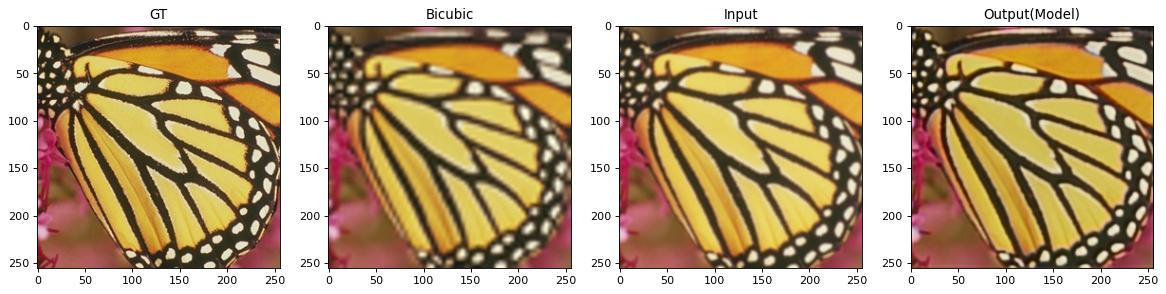

(<PIL.Image.Image image mode=RGB size=256x256 at 0x7F768B9CE670>,
 20.824648960041763,
 15.255986864259103)

In [52]:
display_PSNR(im_gt, im_b, im_b2, model)


In [53]:
im_gt.size

(256, 256)

In [54]:
# Make this load still photos too, and have them added with frame = 0
def test_results(test_dir,scale, display = False):
    instances = []
    psnr_bicubic_sum = 0
    psnr_model_sum = 0
    ct = 0
    
    for filename in listdir(test_dir):
        filepath = os.path.join(test_dir,filename)
        #print(filepath)
                
        if is_image_file(filepath):
            im_gt = Image.open(filepath).convert("RGB")
            #print(im_gt.size)
            
            (height, width) = im_gt.size
            im_b = im_gt.resize((int(height/scale), int(width/scale)), resample = Image.BICUBIC)
            im_b = im_b.resize((height,width), resample = Image.BICUBIC)
            im_b2 = Crappify(crop_size = None, kernel_size=scale*2, quality=90)(im_gt)# open image file
            im_h, psnr_bicubic, psnr_predicted = display_PSNR(im_gt, im_b, im_b2, model, display = display)
            psnr_bicubic_sum = psnr_bicubic_sum + psnr_bicubic
            psnr_model_sum = psnr_model_sum + psnr_predicted
            ct = ct +1
            #item = {"Filepath":filepath, "Type":"image"}
            #instances.append(item)
        
    psnr_bicubic_avg = psnr_bicubic_sum / ct
    psnr_model_avg = psnr_model_sum / ct
        
    print("Bicubic average PSNR =",psnr_bicubic_avg)
    print("Model average PSNR =",psnr_model_avg)
    return 



psnr for bicubic is 20.90886905719583dB
psnr for Model is 20.135357474256807dB
PSNR improvement is -0.7735115829390224dB
Sharpness Measurement GroundTruth: 5109.0955266965975
Sharpness Measurement Bicubic: 15.83579055305556
Sharpness Measurement Input: 21.051232107708337
Sharpness Measurement Model: 21.35038373317708


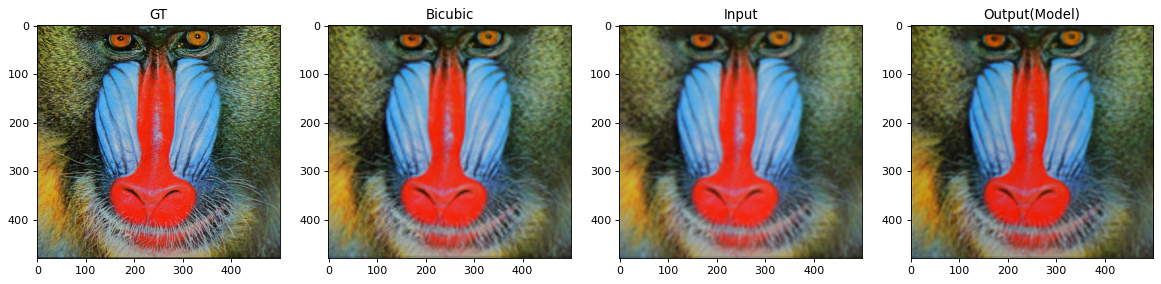

psnr for bicubic is 24.308655657370245dB
psnr for Model is 23.137924808728535dB
PSNR improvement is -1.1707308486417105dB
Sharpness Measurement GroundTruth: 1139.0247193743783
Sharpness Measurement Bicubic: 22.619108417905434
Sharpness Measurement Input: 17.99254485000458
Sharpness Measurement Model: 18.46133384081682


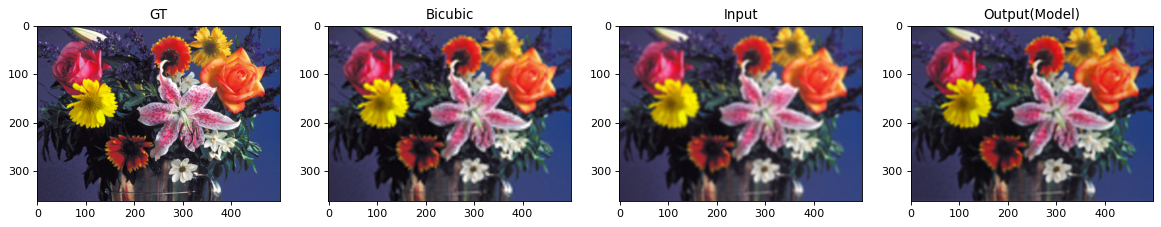

psnr for bicubic is 28.58001966637357dB
psnr for Model is 25.287675710729047dB
PSNR improvement is -3.2923439556445224dB
Sharpness Measurement GroundTruth: 497.13785915203334
Sharpness Measurement Bicubic: 11.100006092106923
Sharpness Measurement Input: 9.885738230179413
Sharpness Measurement Model: 19.476319443201646


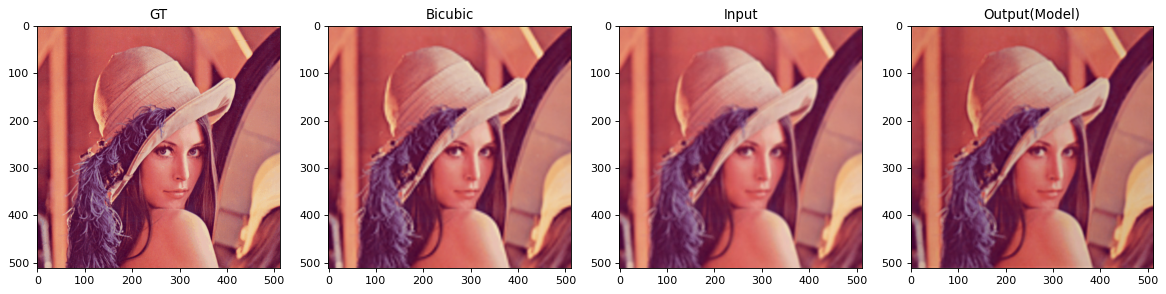

psnr for bicubic is 20.388685221991302dB
psnr for Model is 19.204418385599112dB
PSNR improvement is -1.1842668363921902dB
Sharpness Measurement GroundTruth: 3181.438977407284
Sharpness Measurement Bicubic: 37.289469999876545
Sharpness Measurement Input: 31.34700973777778
Sharpness Measurement Model: 57.77644236839506


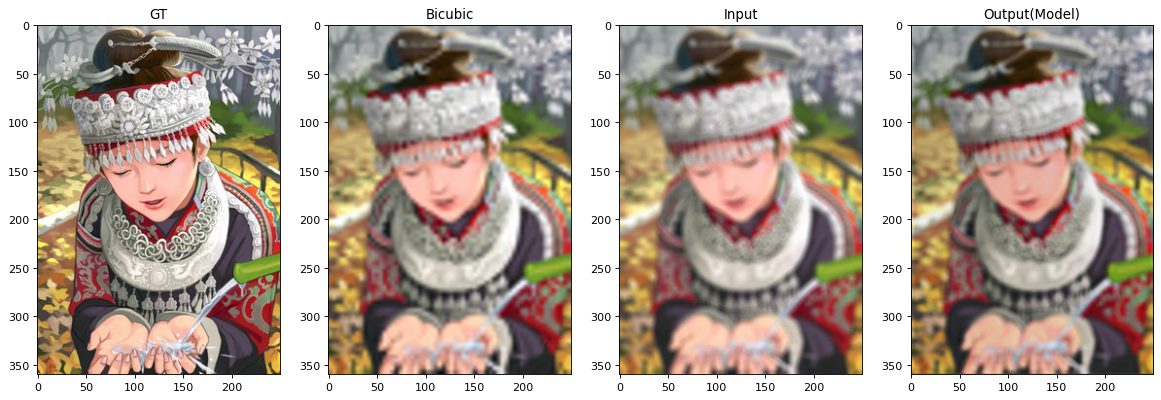

psnr for bicubic is 30.347062508210048dB
psnr for Model is 27.55270377208488dB
PSNR improvement is -2.7943587361251687dB
Sharpness Measurement GroundTruth: 595.7572052363794
Sharpness Measurement Bicubic: 5.924464354118902
Sharpness Measurement Input: 6.287333070855138
Sharpness Measurement Model: 16.55028856260986


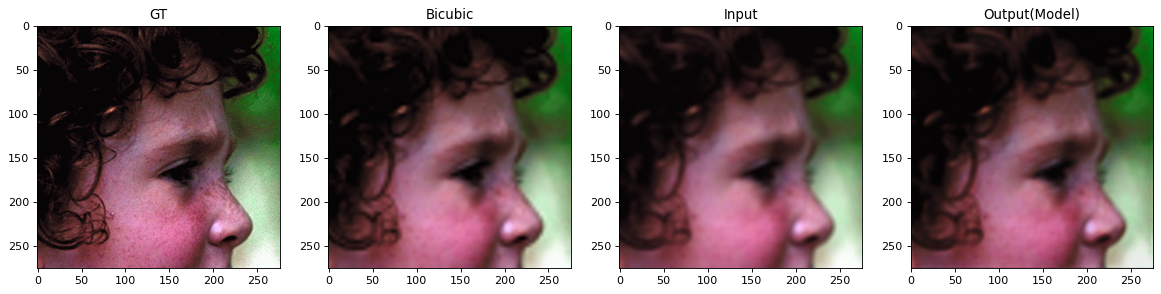

psnr for bicubic is 23.055781743818507dB
psnr for Model is 21.843234250471152dB
PSNR improvement is -1.2125474933473548dB
Sharpness Measurement GroundTruth: 2376.0941899851314
Sharpness Measurement Bicubic: 19.785036861649132
Sharpness Measurement Input: 16.345737375420867
Sharpness Measurement Model: 26.36426281835884


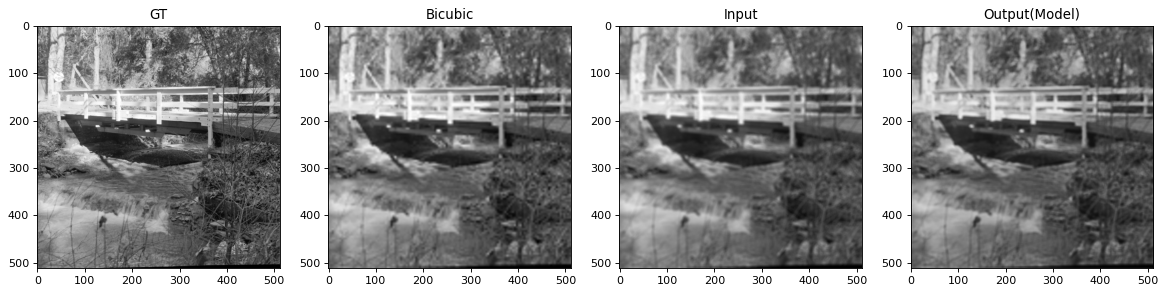

psnr for bicubic is 22.969555994679638dB
psnr for Model is 21.410976893886616dB
PSNR improvement is -1.5585791007930219dB
Sharpness Measurement GroundTruth: 938.4126397093572
Sharpness Measurement Bicubic: 44.872761652286144
Sharpness Measurement Input: 27.378348943398468
Sharpness Measurement Model: 55.33149483387605


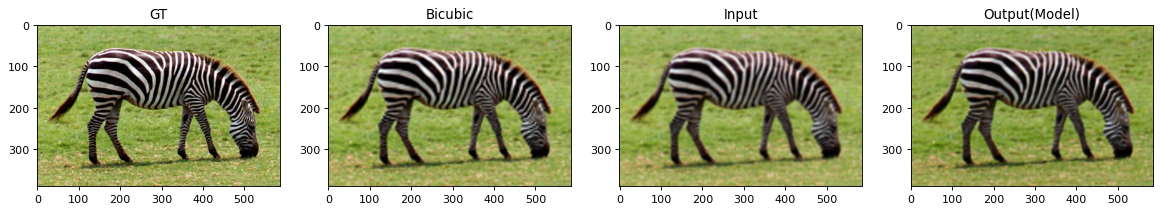

psnr for bicubic is 20.706514438784392dB
psnr for Model is 19.580351103068324dB
PSNR improvement is -1.1261633357160683dB
Sharpness Measurement GroundTruth: 1927.3090995493055
Sharpness Measurement Bicubic: 39.040601296742174
Sharpness Measurement Input: 28.53499432851253
Sharpness Measurement Model: 54.863485578326156


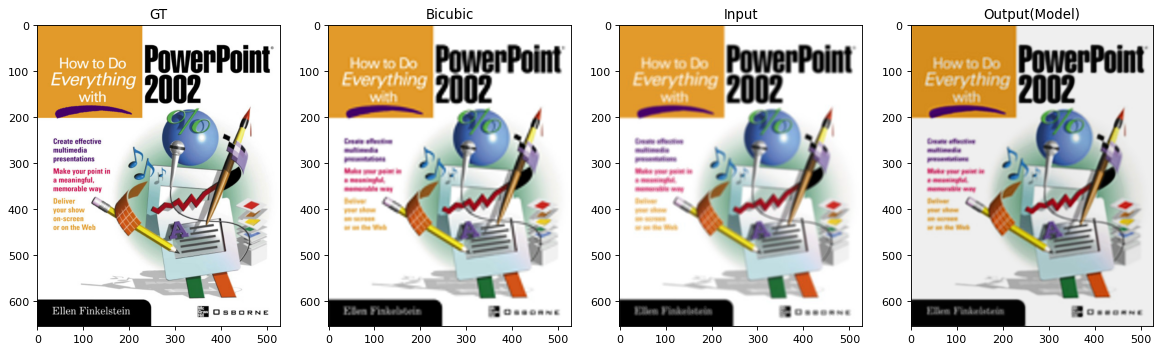

psnr for bicubic is 25.99703094531924dB
psnr for Model is 22.680380478633015dB
PSNR improvement is -3.316650466686223dB
Sharpness Measurement GroundTruth: 739.6683709929154
Sharpness Measurement Bicubic: 15.413530136928086
Sharpness Measurement Input: 12.86552357116581
Sharpness Measurement Model: 33.65319251751439


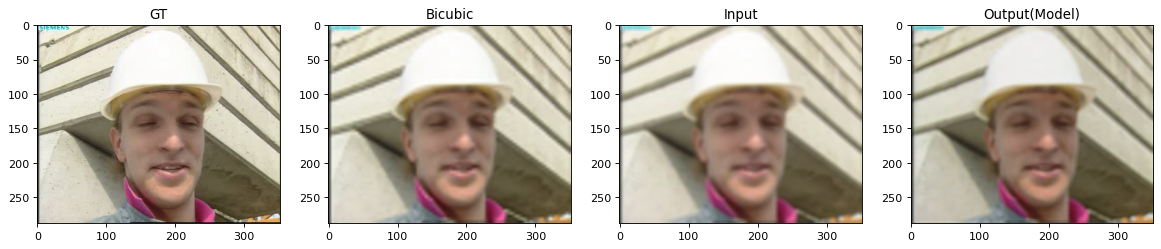

psnr for bicubic is 26.225282739431904dB
psnr for Model is 24.459020745977394dB
PSNR improvement is -1.7662619934545098dB
Sharpness Measurement GroundTruth: 625.6135935834542
Sharpness Measurement Bicubic: 21.235857645612366
Sharpness Measurement Input: 15.449333168404543
Sharpness Measurement Model: 21.692178189754486


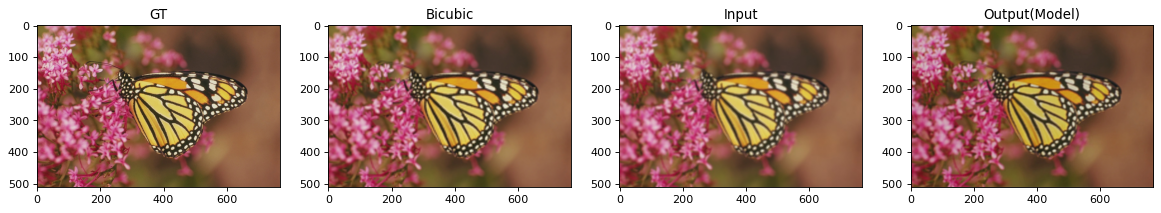

psnr for bicubic is 27.87546946255926dB
psnr for Model is 25.22782357471351dB
PSNR improvement is -2.647645887845748dB
Sharpness Measurement GroundTruth: 785.671896489439
Sharpness Measurement Bicubic: 10.848251492236159
Sharpness Measurement Input: 10.850798537474475
Sharpness Measurement Model: 21.020765293840668


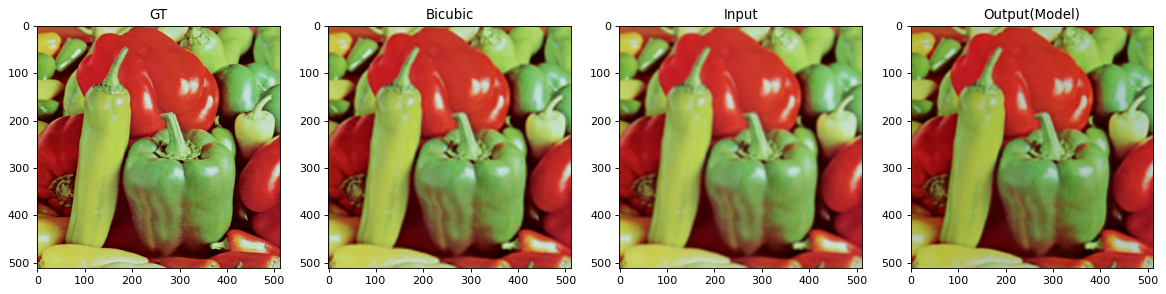

psnr for bicubic is 23.983173916209335dB
psnr for Model is 22.41265345419921dB
PSNR improvement is -1.5705204620101263dB
Sharpness Measurement GroundTruth: 1044.1713580036271
Sharpness Measurement Bicubic: 11.743170487662988
Sharpness Measurement Input: 11.847468523769498
Sharpness Measurement Model: 25.44825224783479


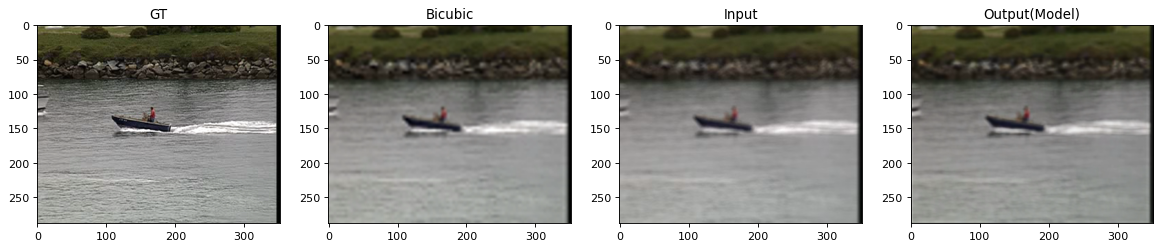

psnr for bicubic is 24.410421920003333dB
psnr for Model is 23.108896934642665dB
PSNR improvement is -1.3015249853606683dB
Sharpness Measurement GroundTruth: 1773.856239214525
Sharpness Measurement Bicubic: 18.433340376010165
Sharpness Measurement Input: 14.513362199286348
Sharpness Measurement Model: 22.375866705653607


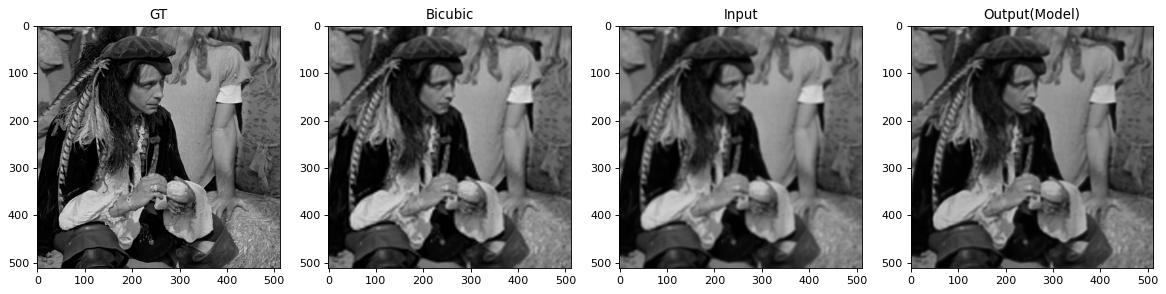

psnr for bicubic is 23.79600530162264dB
psnr for Model is 22.48784015187658dB
PSNR improvement is -1.3081651497460598dB
Sharpness Measurement GroundTruth: 1943.9403096163192
Sharpness Measurement Bicubic: 13.533079124837908
Sharpness Measurement Input: 13.649269657370485
Sharpness Measurement Model: 16.775986310537046


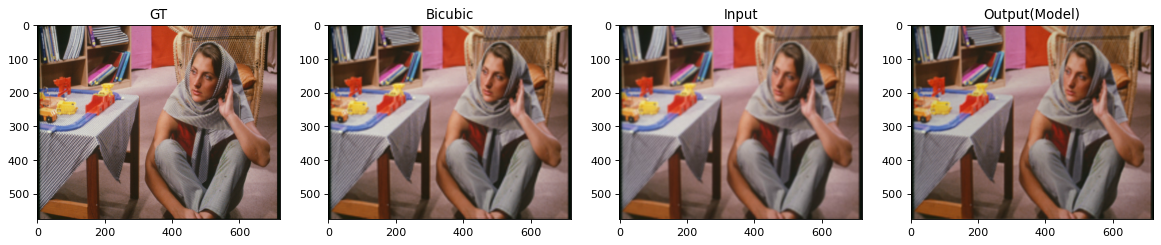

Bicubic average PSNR = 24.539466326683517
Model average PSNR = 22.752089838490487


In [55]:
test_results("/media/SSD/superres/video_data/test_data/Set14", 4, display = True)

# convert sample videos

In [56]:
folder = "/media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuz2/"

In [57]:


infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secespcn2-16.mp4"
superres_mp4(infile, outfile, model, factor=1.6,display=False,bitrate= "4000k")

  0%|          | 0/900 [00:00<?, ?it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuz2/muffins30secespcn2-16.mp4
factor: 1.6 
width= 512 
height= 384 
bitrate= 4000k


/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 900/900 [00:11<00:00, 80.94it/s]


True

In [58]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secespcn2-10.mp4"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k")

  0%|          | 0/900 [00:00<?, ?it/s]/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  3%|▎         | 27/900 [00:00<00:03, 261.03it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuz2/muffins30secespcn2-10.mp4
factor: 1.0 
width= 320 
height= 240 
bitrate= 4000k


100%|██████████| 900/900 [00:03<00:00, 256.89it/s]


True

In [59]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secespcn2-20.mp4"
superres_mp4(infile, outfile, model, factor=2.0,display=False,bitrate= "4000k")

  0%|          | 0/900 [00:00<?, ?it/s]/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  1%|          | 7/900 [00:00<00:13, 64.92it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuz2/muffins30secespcn2-20.mp4
factor: 2.0 
width= 640 
height= 480 
bitrate= 4000k


100%|██████████| 900/900 [00:15<00:00, 58.22it/s]


True

In [60]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secespcn2-30.mp4"
superres_mp4(infile, outfile, model, factor=3.0,display=False,bitrate= "4000k")


  0%|          | 0/900 [00:00<?, ?it/s]/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  0%|          | 3/900 [00:00<00:30, 29.28it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuz2/muffins30secespcn2-30.mp4
factor: 3.0 
width= 960 
height= 720 
bitrate= 4000k


100%|██████████| 900/900 [00:30<00:00, 29.91it/s]


True

In [61]:
dualfile= folder + "muffins30secespcn2-30dual.mp4"

In [62]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [63]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [64]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = folder + "super8espcn2.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/super8_best_from_mp2.mp4
frames= 7195 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuz2/super8espcn2.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


  0%|          | 0/7195 [00:00<?, ?it/s]/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 7195/7195 [01:51<00:00, 64.65it/s]


True

In [65]:

dualfile= folder + "super8espcn2dual.mp4"

In [66]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [67]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuz/super8hespcn1.mp4"
outfile = folder + "super8espcn2.mp4"
dualfile= folder + "super8espcn2-tolast-dual.mp4"

In [68]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [69]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = folder + "super8longespcn2.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/Old 8mm Reels_1.mp4
frames= 121409 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuz2/super8longespcn2.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


  0%|          | 0/121409 [00:00<?, ?it/s]/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 121409/121409 [31:07<00:00, 65.02it/s]


True

In [70]:
dualfile= folder + "super8longespcn2dual.mp4"

In [71]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [ ]:
def dual_superres_mp4(infile, outfile, dualfile, model, factor=1.0,errorfile = error_file):
    
    superres_mp4(infile, outfile, model, factor=factor,display=False,bitrate="4000k",errorfile = error_file)
    
    # original scale , for film x1, removed un needed scaling
    !ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = folder + "super8percepmodel2.mp4"
outfile = folder + "super8percepmodel2x2.mp4"
dualfile= folder + "super8percepmodel2x2x1dual.mp4"
error_file = "/media/SSD/superres/error.txt"

dual_superres_mp4(infile, outfile, dualfile, model, factor=1.0,errorfile = error_file)

infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
dualfile= folder + "super8percepmodel2x2origdual.mp4"

!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}